In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from skimage import io
import os
!pip install opencv-contrib-python==3.4.2.17
import cv2 as cv
import pickle
from skimage.feature import hog
from google.colab import drive
drive.mount('/content/drive')
img_basedir = '/content/drive/My Drive/415Project/'
cropped_img_basedir = "/content/"

     |████████████████████████████████| 30.6MB 137kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
Mounted at /content/drive


In [ ]:
# read from /content for a faster image loading speed
!unzip -q "/content/drive/MyDrive/415Project/result_trimmed.zip" -d "/content"
cropped_img_basedir = "/content/"

# Dataset

## Process Videos

In [ ]:
def parse(filepath):
  '''
      Parse gt.txt / det.txt with format
        <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>
      Return dict as:
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>
      Feel free to edit your structure as needed!
  '''

  lines = open(filepath, "r").readlines()                                 
  bbox = {}
  mask = [False, True, True, True, True, True, False, False, False, False]
  for line in lines:
    line = np.asarray(line.strip().split(',')).astype(np.float32) 
    frame, line = line[0], line[mask]   
    if frame not in bbox.keys():
      bbox[frame] = []   
    bbox[frame].append(line)

  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
    for (_,x,y,dx,dy) in bbox:
      cv.rectangle(annotated, (x, y), (x + dx, y + dy), color , thickness)
  else:
    _,x,y,dx,dy = bbox
    cv.rectangle(annotated, (x, y), (x + dx, y + dy), color , thickness)
  
  return annotated

def crop_instance(img, bbox, frame,setName):
  if (not os.path.exists(img_basedir + 'result/' +setName+ '/' )):
    os.mkdir(img_basedir + "result/" +setName+'/')
  for (id, x, y, dx, dy) in bbox:
    # save as: result/<setname>/<person_id>/<frame_no>_<person_id>
    if(x<0):
      continue
    temp = img[int(y):int(y+dy), int(x):int(x+dx)]
    if (not os.path.exists(img_basedir + 'result/' +setName+ '/' + str(int(id)))):
      os.mkdir(img_basedir + "result/" +setName+'/'+ str(int(id)))

    img_name = img_basedir + 'result/' +setName+'/'+ str(int(id)) + '/' + str(frame) +'_' + str(int(id)) + '.jpg'
    cv.imwrite(img_name, temp)

def process_video(path, vnames):
  for vname in vnames:
    vpath = os.path.join(path, vname)
    bbox = parse(os.path.join(vpath, 'gt.txt'))
    for i in bbox.keys():
      img_name = "{:06n}".format(i) + ".jpg"
      img = mpimg.imread(vpath + "/imgs/" + img_name)
      crop_instance(img, bbox[i], i,vname)
   

In [ ]:
# crop video frames 
path = img_basedir+'MOT15/train/'
vnames = ['TUD-Campus', 'TUD-Stadtmitte', 'ADL-Rundle-6', 'ADL-Rundle-8', 'Venice-2']
process_video(path, vnames)

In [ ]:
def parse_frame(filepath, i):


  lines = open(filepath, "r").readlines()                                 
  bbox = []
  mask = [False, True, True, True, True, True, False, False, False, False]
  for line in lines:
    line = np.asarray(line.strip().split(',')).astype(np.float32) 
    frame, line = line[0], line[mask]   
    if frame == i:
      bbox.append(line)

  return bbox

In [ ]:
path = img_basedir+'MOT15/train/TUD-Campus/gt.txt'
bbox = parse_frame(path, 1)
print(bbox)

[array([  1., 399., 182., 121., 229.], dtype=float32), array([  2., 282., 201.,  92., 184.], dtype=float32), array([  3.,  63., 153.,  82., 288.], dtype=float32), array([  4., 192., 206.,  62., 137.], dtype=float32), array([  5., 125., 209.,  74., 157.], dtype=float32), array([  6., 162., 208.,  55., 145.], dtype=float32)]


## Non-Human objects

In [ ]:
def get_non_human_range(range_list, frame_end):
  '''
    get the ranges without human in it
  '''
  overlapped = [[0, 0]]
  for r in range_list:
    if len(overlapped) == 0:
      overlapped.append(r)
      continue
    
    if r[0] < overlapped[-1][1]:
      overlapped[-1] = [overlapped[-1][0], r[1]]
    else:
      overlapped.append(r)
  overlapped.append([frame_end, frame_end])
  
  non_human_area = []
  for i in range(len(overlapped) - 1):
    non_human_area.append([overlapped[i][1], overlapped[i+1][0]])

  return np.array(non_human_area)


def get_segments(vertical, non_human_range, frame):
  '''
    cut the images into smaller pieces
  '''

  seg = []
  h, w, _ = frame.shape
  vertical_split_range = range(int(h/3), h, int(h/3))
  horizontal_split_range = range(int(h/3), w, int(w/3))
  
  for r in non_human_range:
    if vertical:
      seg.extend(np.split(frame[:, int(r[0]):int(r[1]), :], vertical_split_range, axis=0))
    else:
      seg.extend(np.split(frame[int(r[0]):int(r[1]), :, :], horizontal_split_range, axis=1))

  return seg


def save_non_human_img(imgs, frame_no, save_dir):
  '''
    save all non-human images at: result/<setname>/non_human/<frame_no>_<person_id>
  '''

  if (not os.path.exists(save_dir)):
    os.mkdir(save_dir)

  for i, img in enumerate(imgs):
    if 0 in img.shape:
      # skip invalid image
      i = i - 1
      continue
    
    img_name = os.path.join(save_dir, '%d_%d.jpg' % (frame_no, i))
    cv.imwrite(img_name, img)


def get_non_human_obj_helper(vertical, frame, bbox_list):
  '''
    get the non-human images in a frame
  '''
  
  img_seg = []
  ranges_with_human = []
  bbox_list = np.array(bbox_list)

  # bbx format: <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>
  # get the range with human
  filter = [False, True, False, True, False] if vertical else [False, False, True, False, True]
  ranges_with_human = bbox_list[:, filter]
  ranges_with_human[:, 1] =  ranges_with_human[:, 0] + ranges_with_human[:, 1]
  ranges_with_human = np.sort(ranges_with_human, axis=0)

  # get the range without human
  frame_end = frame.shape[1] if vertical else frame.shape[0]
  non_human_range = get_non_human_range(ranges_with_human, frame_end)

  # get the non-human images
  non_human_imgs = get_segments(vertical, non_human_range, frame)

  return non_human_imgs


def get_non_human_objects(setname, base_path):
  vpath = os.path.join(base_path, setname)
  bbox = parse(os.path.join(vpath, 'gt.txt'))

  set_path = os.path.join(vpath, 'imgs')
  non_human_obj = {}
  for frame_no, bbox_list in bbox.items():
    frame_no = int(frame_no)
    image_path = os.path.join(set_path, "{:06n}.jpg".format(frame_no)) 
    frame = mpimg.imread(image_path)
    non_human_obj[frame_no] = get_non_human_obj_helper(True, frame, bbox_list)
    non_human_obj[frame_no] += get_non_human_obj_helper(False, frame, bbox_list)

    save_dir = os.path.join(img_basedir, 'result', setname, 'non_human')
    save_non_human_img(non_human_obj[frame_no], frame_no, save_dir)
  
  return non_human_obj


In [ ]:
# get non-human cropped imgs in the listed videos
path = img_basedir+'MOT15/train/'
vnames = ['TUD-Campus', 'TUD-Stadtmitte', 'ADL-Rundle-6', 'ADL-Rundle-8', 'Venice-2']
for vname in vnames:
  get_non_human_objects(vname, path)

## Videos Statistics

In [ ]:
def get_dataset_stat(path, vnames):
  # called after process_video and before non_human extraction
  video_stat = {}
  for vname in vnames:
    vpath = os.path.join(path, vname)
    total_imgs = len(os.listdir(os.path.join(vpath, 'imgs')))

    result_path = os.path.join(img_basedir, 'result', vname)
    people_count = {}
    total_person_ids = len(os.listdir(result_path))
    total_people_counts = 0
    for i in range(1, total_person_ids):
      person_path = os.path.join(result_path, str(i))
      person_i_counts = len(os.listdir(person_path))
      total_people_counts += person_i_counts
      people_count[i] = person_i_counts
    video_stat[vname] = people_count
  
  print(video_stat)
  return video_stat


def plot_people_count(people_counts):
  total_videos = len(people_counts.keys())
  fig = plt.figure(figsize=(10,20))
  fig.suptitle('Person Images Distribution')
  for i, v in enumerate(people_counts.keys()):
    plt.subplot(total_videos, 1, i + 1)
    plt.title(v)
    plt.xlabel('people id')
    plt.ylabel('counts for image')
    plt.bar(list(people_count[v].keys()), list(people_count[v].values()))
  plt.tight_layout(total_videos)
  plt.show()


def get_human_non_human_ratio(vnames):
  object_ratio = {}
  for setName in vnames:
    temp = {}
    result_path = os.path.join(img_basedir, 'result', setName)
    temp['non'] = len(os.listdir(os.path.join(result_path, 'non_human')))
    save_dirs_people = os.listdir(result_path)
    save_dirs_people.pop()
    temp['people'] = 0
    for i in save_dirs_people:
      temp['people'] += len(os.listdir(os.path.join(result_path, i)))
    object_ratio[setName] = temp

  print(object_ratio)
  return object_ratio


def plot_human_non_human_ratio(vnames, object_ratio):
  category = ['non_human', 'people']
  total_videos = len(object_ratio.keys())

  fig = plt.figure(figsize=(7,20))
  fig.suptitle = ('Human vs Non-Human Ratio')
  for i, v in enumerate(object_ratio.keys()):
    plt.subplot(total_videos, 1, i + 1)
    plt.title(v)
    plt.ylabel('Count')
    count = [object_ratio[v]['non'], object_ratio[v]['people']]
    plt.bar(category, count)
  plt.tight_layout(total_videos)
  plt.show()


{'TUD-Campus': {1: 24, 2: 43, 3: 63, 4: 71, 5: 71, 6: 9, 7: 42, 8: 25}, 'TUD-Stadtmitte': {1: 19, 2: 120, 3: 179, 4: 89, 5: 62, 6: 179, 7: 179, 8: 174, 9: 106, 10: 46}, 'ADL-Rundle-6': {1: 195, 2: 252, 3: 381, 4: 490, 5: 376, 6: 171, 7: 233, 8: 137, 9: 80, 10: 40, 11: 161, 12: 322, 13: 247, 14: 50, 15: 272, 16: 250, 17: 334, 18: 316, 19: 271, 20: 80, 21: 77, 22: 57, 23: 98, 24: 119}, 'ADL-Rundle-8': {1: 90, 2: 654, 3: 55, 4: 654, 5: 50, 6: 76, 7: 220, 8: 333, 9: 52, 10: 250, 11: 140, 12: 94, 13: 583, 14: 440, 15: 654, 16: 212, 17: 68, 18: 10, 19: 40, 20: 411, 21: 147, 22: 270, 23: 233, 24: 236, 25: 261, 26: 268, 27: 40, 28: 242}, 'Venice-2': {1: 544, 2: 573, 3: 50, 4: 40, 5: 320, 6: 290, 7: 346, 8: 261, 9: 241, 10: 579, 11: 330, 12: 225, 13: 50, 14: 190, 15: 518, 16: 600, 17: 240, 18: 70, 19: 200, 20: 210, 21: 81, 22: 360, 23: 207, 24: 177, 25: 119, 26: 320}}


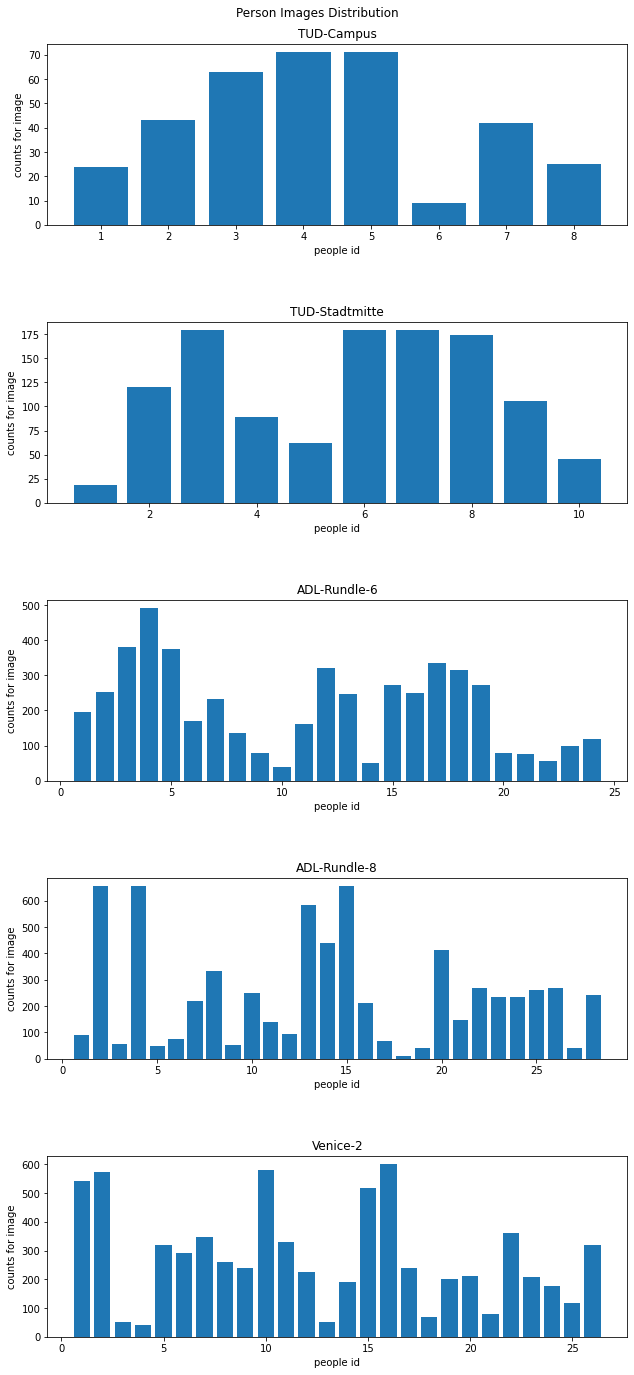

In [ ]:
# print the statistic
path = img_basedir+'MOT15/train/'
vnames = ['TUD-Campus', 'TUD-Stadtmitte', 'ADL-Rundle-6', 'ADL-Rundle-8', 'Venice-2']
people_count = get_dataset_stat(path, vnames)
plot_people_count(people_count)

{'TUD-Campus': {'non': 1306, 'people': 348}, 'TUD-Stadtmitte': {'non': 4240, 'people': 1153}, 'ADL-Rundle-6': {'non': 11409, 'people': 5009}, 'ADL-Rundle-8': {'non': 20946, 'people': 6783}, 'Venice-2': {'non': 15700, 'people': 7141}}


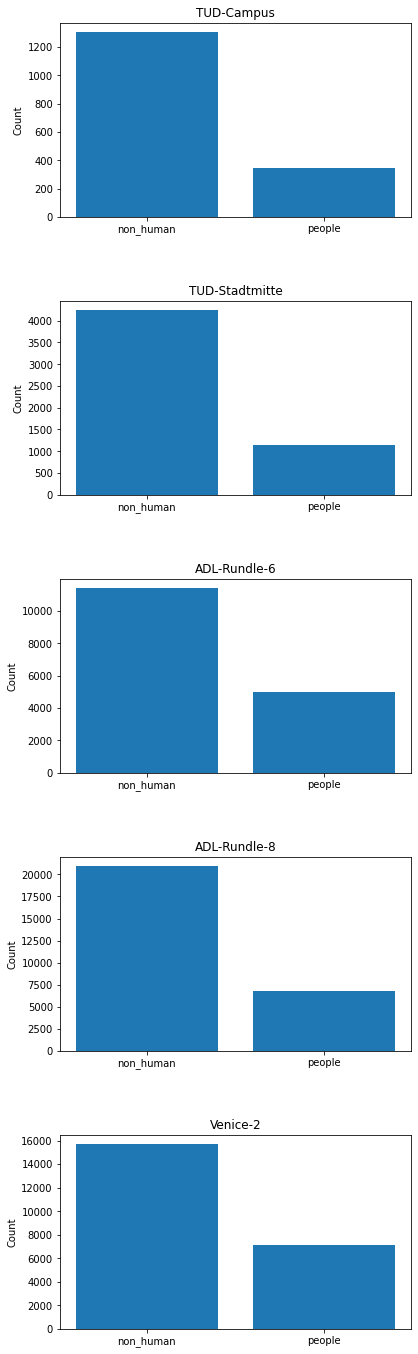

In [ ]:
object_ratio = get_human_non_human_ratio(vnames)
plot_human_non_human_ratio(vnames, object_ratio)

# Classification

## Feature Extraction and Model

In [ ]:
def get_training_dataset(train_path):
  # img in gray scale
  x_train = []
  y_train = []
  # get the training features and labels
  imgs = os.listdir(train_path)
  for folder in imgs:
    folders = os.listdir(os.path.join(train_path, folder))
    # print("new" + folder)
    for img in folders:
      image = cv.imread(os.path.join(os.path.join(train_path, folder), img), 0)
      if image is None:
        continue
      # print(os.path.join(os.path.join(train_path, folder),img))
      image = cv.resize(image, (80,160), interpolation = cv.INTER_AREA)
      x_train.append(image)
      cate = 0
      if folder == "non_human":
        cate = 0
      else:
        cate = 1
      #print(cate)
      y_train.append(cate)
  return x_train, y_train

def get_testing_dataset(test_path):
  # get the testing features and labels
  x_test = []
  imgs = os.listdir(test_path)
  for img in imgs:
    image = cv.imread(os.path.join(test_path, img), 0)
    x_test.append(image)
  return x_test
    


In [ ]:
data1 = cropped_img_basedir + "result_trimmed/TUD-Campus"
data2 = cropped_img_basedir + "result_trimmed/TUD-Stadtmitte"
data3 = cropped_img_basedir + "result_trimmed/ADL-Rundle-6"
data4 = cropped_img_basedir + "result_trimmed/ADL-Rundle-8"
data5 = cropped_img_basedir + "result_trimmed/Venice-2"
x1, y1 = get_training_dataset(data1)
x2, y2 = get_training_dataset(data2)
x3, y3 = get_training_dataset(data3)
x4, y4 = get_training_dataset(data4)
x5, y5 = get_training_dataset(data5)

In [ ]:
def hog_tune_parameter():
  x_hog_1 = hog_data(np.asarray(x1))
  svm_clf = svm.SVC(C = 10, gamma= 0.1, kernel = 'rbf')
  n_data_to_use =1300
  x_train = np.asarray(x_hog_1)
  y_train = np.asarray(y1)
  
  clf.fit(x_train[:n_data_to_use, :], y_train[:n_data_to_use])
  x_val = np.asarray(x_hog_1)[n_data_to_use:, :]
  y_val = y_train[n_data_to_use:]
  y_predict = clf.predict(x_val)
  pos = 0
  for n in range(y_val.shape[0]):
    if y_predict[n] == y_val[n]:
      pos = pos + 1
  accuracy = pos/y_val.shape[0]
  print(accuracy)

In [ ]:
from sklearn import svm
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=6, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()


0.9452887537993921


In [ ]:
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=6, pixels_per_cell=(6, 6),cells_per_block=(4, 4),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()

0.9057750759878419


In [ ]:
from sklearn import svm
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=6, pixels_per_cell=(2, 2),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()

0.9483282674772037


In [ ]:
from sklearn import svm
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()

0.9665653495440729


In [ ]:
from sklearn import svm
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=9, pixels_per_cell=(2, 2),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()

0.9817629179331308


In [ ]:
from sklearn import svm
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(4, 4),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

hog_tune_parameter()

0.9483282674772037


In [ ]:
from skimage.feature import hog
def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

x_hog_1 = hog_data(np.asarray(x1))
x_hog_2 = hog_data(np.asarray(x2))
x_hog_3 = hog_data(np.asarray(x3))
x_hog_4 = hog_data(np.asarray(x4))
x_hog_5 = hog_data(np.asarray(x5))

In [ ]:
from skimage.feature import hog

def hog_data(x):
  result = []
  for img in x:
    hist =  hog(img, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    result.append(hist)
  return result

x_hog_1 = hog_data(np.asarray(x1))


In [ ]:
from sklearn.decomposition import PCA
import math
def find_min_dataset_size():
  x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
  min = math.inf
  for i in range(5):
    x_train = []

    for j in range(5):
      if (i==j):
        continue
      x_train = x_train+x[j]
    min = len(x_train) if min > len(x_train) else min
  return min

def cross_validation(clf, model_name, use_pca=False):
  x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
  y = [y1, y2, y3, y4, y5]
  acc = []
  n_data_to_use = 10000
  for i in range(5):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for j in range(5):
      if (i==j):
        x_val = x[j]
        y_val = y[j]
      else:
        x_train = x_train+x[j]
        y_train = y_train+y[j]

    x_train = np.asarray(x_train)

    x_val = np.asarray(x_val)

    if use_pca:
      pca = PCA(n_components=4000).fit(x_train)
      x_train = pca.transform(x_train)
      x_val = pca.transform(x_val)

    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)

    print(x_train.shape)
    clf.fit(x_train[:n_data_to_use, :], y_train[:n_data_to_use])
    y_predict = clf.predict(x_val)
    pos = 0
    for n in range(y_val.shape[0]):
      if y_predict[n] == y_val[n]:
        pos = pos + 1
    accuracy = pos/y_val.shape[0]
    acc.append(accuracy)
    print(accuracy)

    # save the trained model to pkl
    hog_clf_path = img_basedir + 'hog_{}_fold_{}.pickle'.format(model_name, i)
    hog_clf_store = open(hog_clf_path, 'wb')
    pickle.dump(clf, hog_clf_store)

In [ ]:
def cross_validation(clf, model_name, use_pca=False):
  x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
  y = [y1, y2, y3, y4, y5]
  acc = []
  n_data_to_use = 10000
  for i in range(len(x)):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for j in range(len(x)):
      if (i==j):
        x_val = x[j]
        y_val = y[j]
      else:
        x_train = x_train+x[j]
        y_train = y_train+y[j]

    x_train = np.asarray(x_train)

    x_val = np.asarray(x_val)

    if use_pca:
      pca = PCA(n_components=4000).fit(x_train)
      x_train = pca.transform(x_train)
      x_val = pca.transform(x_val)

    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)

    print(x_train.shape)
    clf.fit(x_train[:n_data_to_use, :], y_train[:n_data_to_use])
    y_predict = clf.predict(x_val)
    pos = 0
    tp = 0
    fp = 0
    fn = 0
    for n in range(y_val.shape[0]):
      if y_predict[n] == y_val[n]:
        pos = pos + 1
        if y_val[n] == 1:
          tp = tp+1 
      if y_predict[n] != y_val[n]:
        if y_predict[n] == 1:
          fp += 1
        if y_predict[n] == 0:
          fn += 1
    accuracy = pos/y_val.shape[0]
    acc.append(accuracy)
    print("fold " + str(i))
    print("accuracy = " + str(accuracy))
    print("precision = " + str(tp/(tp+fp)))
    print("recall = " + str(tp/(tp+fn)))

    # save the trained model to pkl
    hog_clf_path = img_basedir + 'hog_{}_fold_{}.pickle'.format(model_name, i)
    hog_clf_store = open(hog_clf_path, 'wb')
    pickle.dump(clf, hog_clf_store)

In [ ]:
from sklearn.decomposition import PCA
def print_metrics(clf, x_val, y_val, isPca, x_train):
    y_val = np.asarray(y_val)
    x_val = np.asarray(x_val)
    if isPca==True:
      pca = PCA(n_components=4000).fit(x_train)
      x_val = pca.transform(x_val)
    y_predict = clf.predict(x_val)

    pos = 0
    tp = 0
    fp = 0
    fn = 0
    for n in range(y_val.shape[0]):
      if y_predict[n] == y_val[n]:
        pos = pos + 1
        if y_val[n] == 1:
          tp = tp+1 
      if y_predict[n] != y_val[n]:
        if y_predict[n] == 1:
          fp += 1
        if y_predict[n] == 0:
          fn += 1
    accuracy = pos/y_val.shape[0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print("accuracy = " + str(accuracy))
    print("precision = " + str(tp/(tp+fp)))
    print("recall = " + str(tp/(tp+fn)))
    return accuracy, precision, recall

## HOG + SVM

In [ ]:
from sklearn import svm
svm_clf = svm.SVC(C = 10, gamma= 0.1, kernel = 'rbf')
cross_validation(svm_clf, 'SVM')

(21658, 10800)
0.8888888888888888
(17970, 10800)
0.9236411510250141
(6946, 10800)
0.5980050180527507


In [ ]:
x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
y = [y1, y2, y3, y4, y5]
accs = []
pres = []
recs = []
for i in range(5):
  hog_clf_path = img_basedir + 'hog_SVM_fold_' + str(i) +'.pickle'
  hog_clf_store = open(hog_clf_path, 'rb')
  clf = pickle.load(hog_clf_store)
  print("fold" + str(i))
  acc, pre, rec = print_metrics(clf, x[i], y[i], False, np.asarray(x_hog_1))
  accs.append(acc)
  pres.append(pre)
  recs.append(rec)
print("mean accuracy = " + str(np.mean(np.asarray(accs))))
print("standard deviation = " + str(np.std(np.asarray(accs))))
print("mean precision = " + str(np.mean(np.asarray(pres))))
print("mean recall = " + str(np.mean(np.asarray(recs))))

fold0
accuracy = 0.8569674647022714
precision = 0.6028622540250447
recall = 0.9683908045977011
fold1
accuracy = 0.9445266272189349
precision = 0.9469623915139826
recall = 0.9117920148560817
fold2
accuracy = 0.6855947399880454
precision = 0.6073496098665996
recall = 0.9925956396544632
fold3
accuracy = 0.7595603389054271
precision = 0.6591139668583024
recall = 0.9789050728277248
fold4
accuracy = 0.873066880899779
precision = 0.8184168012924071
recall = 0.9731079523626585
mean accuracy = 0.8239432103428914
standard deviation = 0.09091705032009684
mean precision = 0.7269410047112672
mean recall = 0.9649582968597258


## HOG + PCA + SVM

In [ ]:
# with pca
from sklearn import svm
svm_clf = svm.SVC(C = 10, gamma= 0.1, kernel = 'rbf')
cross_validation(svm_clf, 'svm_pca', True)

(21658, 4000)
0.3842848373235114
(17970, 4000)
0.8920443859319165
(6946, 4000)
0.612141239826204


In [ ]:
svm_acc = np.array([0.38428, 0.8920, 0.6121])
svm_mean = np.mean(svm_acc)
svm_var = np.var(svm_acc)
print("mean: " + str(svm_mean))
print("var: " + str(svm_var))

mean: 0.62946
var: 0.0431139512


In [ ]:
x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
y = [y1, y2, y3, y4, y5]
accs = []
pres = []
recs = []
for i in range(5):
  x_train = []
  for j in range(5):
    if i!=j:
      x_train +=x[i]
  hog_clf_path = img_basedir + 'hog_svm_pca_fold_' + str(i) +'.pickle'
  hog_clf_store = open(hog_clf_path, 'rb')
  clf = pickle.load(hog_clf_store)
  print("fold" + str(i))
  acc, pre, rec = print_metrics(clf, x[i], y[i], True, x_train)
  accs.append(acc)
  pres.append(pre)
  recs.append(rec)
print("mean accuracy = " + str(np.mean(np.asarray(accs))))
print("standard deviation = " + str(np.std(np.asarray(accs))))
print("mean precision = " + str(np.mean(np.asarray(pres))))
print("mean recall = " + str(np.mean(np.asarray(recs))))

fold0
accuracy = 0.8453038674033149
precision = 0.58
recall = 1.0
fold1
accuracy = 0.8443047337278107
precision = 0.739067055393586
recall = 0.9415041782729805
fold2
accuracy = 0.7389918310420402
precision = 0.7117491499811107
recall = 0.7749897161661867
fold3
accuracy = 0.790245019464163
precision = 0.7001862197392924
recall = 0.9442491210447012
fold4
accuracy = 0.7459329182566781
precision = 0.7463181148748159
recall = 0.7787168651555897
mean accuracy = 0.7929556739788015
standard deviation = 0.04584243195996748
mean precision = 0.695464107997761
mean recall = 0.8878919761278915


## HOG + AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()
cross_validation(adaboost, 'Adaboost')

In [ ]:
x = [x_hog_1, x_hog_2, x_hog_3, x_hog_4, x_hog_5]
y = [y1, y2, y3, y4, y5]
accs = []
pres = []
recs = []
for i in range(5):
  hog_clf_path = img_basedir + 'hog_Adaboost_fold_' + str(i) +'.pickle'
  hog_clf_store = open(hog_clf_path, 'rb')
  clf = pickle.load(hog_clf_store)
  print("fold" + str(i))
  acc, pre, rec = print_metrics(clf, x[i], y[i], False, np.asarray(x_hog_1))
  accs.append(acc)
  pres.append(pre)
  recs.append(rec)
print("mean accuracy = " + str(np.mean(np.asarray(accs))))
print("standard deviation = " + str(np.std(np.asarray(accs))))
print("mean precision = " + str(np.mean(np.asarray(pres))))
print("mean recall = " + str(np.mean(np.asarray(recs))))


fold0
accuracy = 0.8244321669736034
precision = 0.5591603053435115
recall = 0.8419540229885057
fold1
accuracy = 0.8439349112426036
precision = 0.8182701652089407
recall = 0.7818012999071495
fold2
accuracy = 0.7650926479378363
precision = 0.6926153846153846
recall = 0.9259563965446318
fold3
accuracy = 0.8101671628119991
precision = 0.7876237623762377
recall = 0.7990959316926167
fold4
accuracy = 0.8025707973488653
precision = 0.8494391716997411
recall = 0.7564348828275067
mean accuracy = 0.8092395372629815
standard deviation = 0.02618726939334396
mean precision = 0.741421757848763
mean recall = 0.8210485067920821


In [ ]:
os.listdir("/content/drive/My Drive/415Project/")


['MOT15',
 'hog_clf_store.pickle',
 'hog_clf_0or1_store.pickle',
 'methods_IoU',
 'test-train-split-vars',
 'K-fold.ipynb',
 'result.zip',
 'hog_clf_3_videos.pickle',
 'hog_adaboost_fold_1.pickle',
 'hog_adaboost_fold_0.pickle',
 'hog_adaboost_fold_2.pickle',
 'mohammad',
 'result_trimmed.zip',
 'hog_svm_pca_fold_0.pickle',
 'hog_svm_pca_fold_1.pickle',
 'hog_svm_pca_fold_2.pickle',
 'hog_svm_pca_fold_3.pickle',
 'hog_svm_pca_fold_4.pickle',
 'To-Do.gsheet',
 'result',
 'conclusion script.gdoc',
 'presentation',
 '415Discussion.mp4',
 'pca_5_fold.pickle',
 'pca_fold_4.pickle',
 'pca_fold_3.pickle',
 'omar_test.ipynb',
 '415Presentation.pptx',
 'Report.gdoc',
 'main_project_collab.ipynb',
 'hog_SVM_fold_0.pickle',
 'hog_SVM_fold_1.pickle',
 'hog_SVM_fold_2.pickle',
 'hog_SVM_fold_3.pickle',
 'hog_SVM_fold_4.pickle']

In [ ]:
hog_adaboost_fold_3.pickle hog_adaboost_fold_3.pickle

In [ ]:
ada_acc = np.array([0.6875, 0.8516, 0.7038])
ada_mean = np.mean(ada_acc)
ada_var = np.var(ada_acc)
print("mean: " + str(ada_mean))
print("var: " + str(ada_var))

mean: 0.7476333333333333
var: 0.005448815555555558


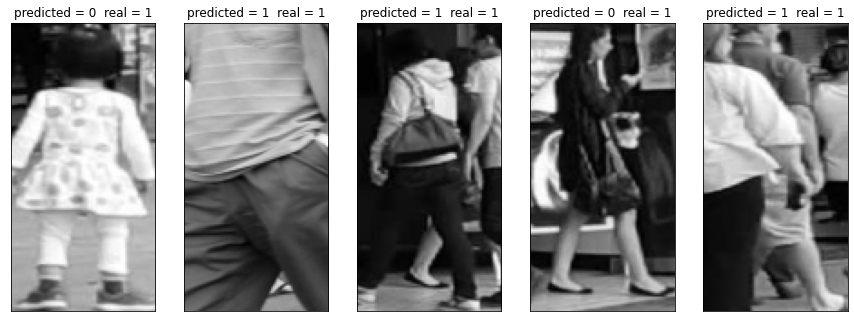

In [ ]:
# load trained model
np.random.seed()
plt.rcParams['figure.figsize'] = (15,6)
for i in range(5):
  n = np.random.randint(len(x_hog_3))
  while y3[n] == 0:
    n = np.random.randint(len(x_hog_3))
  hog_clf_path = img_basedir + 'hog_adaboost_fold_2.pickle'
  hog_clf_store = open(hog_clf_path, 'rb')
  clf = pickle.load(hog_clf_store)
  t3 = np.asarray(x_hog_3[n])
  t3 = t3.reshape(1,t3.shape[0])
  pt3 = clf.predict(t3)
  l3 = y3[n]
  x3 = np.asarray(x3)
  plt.subplot(1, 5, i+1)
  plt.title("predicted = " + str(pt3[0]) + "  real = " + str(l3) )
  plt.imshow(x3[n], cmap="gray")
  plt.xticks([])
  plt.yticks([])
plt.show()

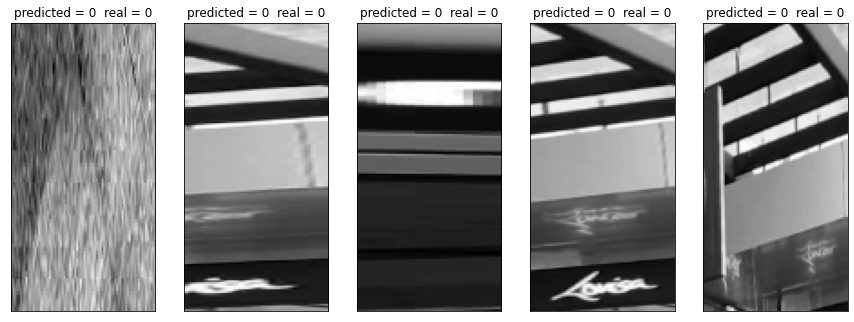

In [ ]:
# load trained model
np.random.seed()
plt.rcParams['figure.figsize'] = (15,6)
for i in range(5):
  n = np.random.randint(len(x_hog_3))
  while y3[n] == 1:
    n = np.random.randint(len(x_hog_3))
  hog_clf_path = img_basedir + 'hog_adaboost_fold_2.pickle'
  hog_clf_store = open(hog_clf_path, 'rb')
  clf = pickle.load(hog_clf_store)
  t3 = np.asarray(x_hog_3[n])
  t3 = t3.reshape(1,t3.shape[0])
  pt3 = clf.predict(t3)
  l3 = y3[n]
  x3 = np.asarray(x3)
  plt.subplot(1, 5, i+1)
  plt.title("predicted = " + str(pt3[0]) + "  real = " + str(l3) )
  plt.imshow(x3[n], cmap="gray")
  plt.xticks([])
  plt.yticks([])
plt.show()

## previous code

In [ ]:
train_path_campus = img_basedir + "result/TUD-Campus"
train_path_stadtmitte = img_basedir + "result/TUD-Stadtmitte"
test_path = img_basedir + "MOT15/test/TUD-Crossing/imgs"
x_train_campus, y_train_campus = get_training_dataset(train_path_campus)
x_train_sta, y_train_sta = get_training_dataset(train_path_stadtmitte)
x_test = get_testing_dataset(test_path)

In [ ]:
print("x_train_campus length: {}".format(len(x_train_campus)))
print("y_train_campus length: {}".format(len(y_train_campus)))
print("x_train_sta length: {}".format(len(x_train_sta)))
print("y_train_sta length: {}".format(len(y_train_sta)))
print("x_test length: {}".format(len(x_test)))

x_train_campus length: 1654
y_train_campus length: 1654
x_train_sta length: 5392
y_train_sta length: 5392
x_test length: 201


In [ ]:
sift = cv.xfeatures2d.SIFT_create()
result_dir = img_basedir + 'result/'
descriptors_campus = []
for i in x_train_campus:
  #gray= cv.cvtColor(i,cv.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(i,None)
  try:
    if len(descriptors_campus) == 0:
      if des.shape[0] > 20:
        descriptors_campus = des[:20]
      else:
        descriptors_campus = des
    else:
      if des.shape[0] > 20:
        descriptors_campus = np.concatenate((descriptors_campus,des[:20]),axis = 0)
      else:
        descriptors_campus = np.concatenate((descriptors_campus,des),axis = 0)
  except:
    continue



descriptors_sta = []
for i in x_train_sta:
  #print(i)
  #gray= cv.cvtColor(i,cv.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(i,None)
  try:
    if len(descriptors_sta) == 0:
      if des.shape[0] > 20:
        descriptors_sta = des[:20]
      else:
        descriptors_sta = des
    else:
      if des.shape[0] > 20:
        descriptors_sta = np.concatenate((descriptors_sta,des[:20]),axis = 0)
      else:
        descriptors_sta = np.concatenate((descriptors_sta,des),axis = 0)
  except:
    continue

In [ ]:
print(descriptors_sta.shape,descriptors_campus.shape)

(88489, 128) (25556, 128)


In [ ]:
from sklearn.cluster import KMeans
kmeans_campus = KMeans(n_clusters=150)
kmeans_sta = KMeans(n_clusters=170)
kmeans_campus.fit(descriptors_campus)
kmeans_sta.fit(descriptors_sta)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=170, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
x_feature_train_campus = []
for i in x_train_campus:
  #gray= cv.cvtColor(i,cv.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(i,None)
  des_feature = [0 for i in range(150)]
  try:
    if des.shape[0] > 20:
      temp = des[:20]
    else:
      temp = des
    for i in range(temp.shape[0]):
      feat = np.expand_dims(temp[i], axis=0)
      index = kmeans_campus.predict(feat)[0]
      des_feature[index] = des_feature[index] + 1
    x_feature_train_campus.append(des_feature)
  except:
    x_feature_train_campus.append([0 for i in range(150)])

In [ ]:
x_feature_train_sta = []
for i in x_train_sta:
  #gray= cv.cvtColor(i,cv.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(i,None)
  des_feature = [0 for i in range(170)]
  try:
    if des.shape[0] > 20:
      temp = des[:20]
    else:
      temp = des
    for i in range(temp.shape[0]):
      feat = np.expand_dims(temp[i], axis=0)
      index = kmeans_sta.predict(feat)[0]
      des_feature[index] = des_feature[index] + 1
    x_feature_train_sta.append(des_feature)
  except:
    x_feature_train_sta.append([0 for i in range(170)])

In [ ]:
x_feature_train_sta = np.array(x_feature_train_sta)
x_feature_train_campus = np.array(x_feature_train_campus)

In [ ]:
print(x_feature_train_sta.shape)
print(x_feature_train_campus.shape)

(5392, 170)
(1654, 150)


In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0, cv=5)

# -----

print("Campus: \n")

# fitting the model for grid search
grid.fit(x_feature_train_campus, y_train_campus)

# print best parameter after tuning
print("Best parameters: {}".format(grid.best_params_))
  
# print how our model looks after hyper-parameter tuning
print("Model after hyper-parameter tuning: \n{}".format(grid.best_estimator_))

# check mean score for the top performing hyper-parameter combination
print("Mean score for top performing value hyper-parameter combination: {}".format(grid.best_score_))
print("Therefore the mean accuracy of KNN 5-fold cross-validation is: {}".format(grid.best_score_ * 100))

prediction = grid.predict(x_feature_train_campus[:348])
print(prediction.tolist())
# -----

print("\nStadtmitte: \n")
grid1 = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0, cv=5)
# fitting the model for grid search
grid1.fit(x_feature_train_sta, y_train_sta)

# print best parameter after tuning
print("Best parameters: {}".format(grid1.best_params_))
  
# print how our model looks after hyper-parameter tuning
print("Model after hyper-parameter tuning: \n{}".format(grid1.best_estimator_))

# check mean score for the top performing hyper-parameter combination
print("Mean score for top performing value hyper-parameter combination: {}".format(grid1.best_score_))
print("Therefore the mean accuracy of KNN 5-fold cross-validation is: {}".format(grid1.best_score_ * 100))

# # default rbf kernel used
# clf_campus = svm.SVC(gamma=0.001, C=100.)
# scores_campus = cross_val_score(clf_campus,x_feature_train_campus,y_train_campus, cv=5)
# # default rbf kernel used
# clf_sta = svm.SVC(gamma=0.001, C=100.)
# scores_sta = cross_val_score(clf_sta,x_feature_train_sta,y_train_sta, cv=5)

Campus: 

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Model after hyper-parameter tuning: 
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Mean score for top performing value hyper-parameter combination: 0.8512752906710611
Therefore the mean accuracy of KNN 5-fold cross-validation is: 85.12752906710611
['1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3

In [ ]:
print("Campus")
print("standard deviation: "+ str(grid.cv_results_['std_test_score'][grid.best_index_]))

print("Stadtmitte")
print("standard deviation: "+ str(grid1.cv_results_['std_test_score'][grid1.best_index_]))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# create new a knn model
knn_cv = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 10)}

# use gridsearch to test all values for n_neighbors
# 5-fold cross validation used
knn_gscv = GridSearchCV(knn_cv, param_grid, cv=5)

# ------

print("Campus: \n")

# fit model to data for Campus
knn_gscv.fit(x_feature_train_campus, y_train_campus)

# check top performing n_neighbors value
knn_gscv.best_params_
print("Best number of neighbours: {}".format(knn_gscv.best_params_))

# check mean score for t``p he top performing value of n_neighbors
print("Mean score for top performing value of n_neighbours: {}".format(knn_gscv.best_score_))
print("Therefore the mean accuracy of KNN 5-fold cross-validation is: {}".format(knn_gscv.best_score_ * 100))

# ------

print("\nStadtmitte: \n")
knn_gscv1 = GridSearchCV(knn_cv, param_grid, cv=5)

# fit model to data for Stadtmitte
knn_gscv1.fit(x_feature_train_sta, y_train_sta)

# check top performing n_neighbors value
knn_gscv1.best_params_
print("Best number of neighbours: {}".format(knn_gscv1.best_params_))

# check mean score for the top performing value of n_neighbors
print("Mean score for top performing value of n_neighbours: {}".format(knn_gscv1.best_score_))
print("Therefore the mean accuracy of KNN 5-fold cross-validation is: {}".format(knn_gscv1.best_score_ * 100))

Campus: 

Best number of neighbours: {'n_neighbors': 1}
Mean score for top performing value of n_neighbours: 0.8107626110043029
Therefore the mean accuracy of KNN 5-fold cross-validation is: 81.07626110043029

Stadtmitte: 

Best number of neighbours: {'n_neighbors': 7}
Mean score for top performing value of n_neighbours: 0.8124997205892214
Therefore the mean accuracy of KNN 5-fold cross-validation is: 81.24997205892214


In [ ]:
print("Campus")
print("standard deviation: "+ str(knn_gscv.cv_results_['std_test_score'][knn_gscv.best_index_]))

print("Stadtmitte")
print("standard deviation: "+ str(knn_gscv1.cv_results_['std_test_score'][knn_gscv1.best_index_]))

# Detection and Localization

continue working on the previous best svm model with TUD-Stadtmitte as the validation set

In [ ]:
# read color img
def get_color_imgs(vname, path):
  color_imgs = []
  vpath = os.path.join(path, vname)
  bbox = parse(os.path.join(vpath, 'gt.txt'))
  for i in bbox.keys():
    img_name = "{:06n}".format(i) + ".jpg"
    img = cv.imread(vpath + "/imgs/" + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    color_imgs.append(img)
  return color_imgs

In [ ]:
from imutils.object_detection import non_max_suppression
from skimage.transform import pyramid_gaussian
from skimage.feature import hog


def sliding_window(image, window_size, step_size):
  for y in range(0, image.shape[0], step_size[1]):
    for x in range(0, image.shape[1], step_size[0]):
      yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

def detector(img, clf, pca=None, display_result=True):
  img_temp = img.copy()
  im = cv.cvtColor(img_temp, cv.COLOR_RGB2GRAY) 
  window_size = (64, 128) # width, height
  step_size = (15, 15) # step size for x, step size for y
  downscale = 1.5

  #List to store the detections
  detections = []
  scale = 0

  for im_scaled in pyramid_gaussian(im, downscale=downscale):
    if im_scaled.shape[0] < window_size[1] or im_scaled.shape[1] < window_size[0]:
      break
    for (x, y, im_window) in sliding_window(im_scaled, window_size, step_size):
      if im_window.shape[0] != window_size[1] or im_window.shape[1] != window_size[0]:
        continue
      # fd_temp = []
      im_window = cv.resize(im_window, (80,160), interpolation = cv.INTER_AREA)
      features = hog(im_window, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)         
      # fd_temp.append(hist)
      # fd_temp = np.asarray(fd_temp)
      if pca != None:
        features = pca.transform(features.reshape(1, -1))
      pred = clf.predict(features)
      
      if pred[0] != '0':
        decision_value = clf.decision_function(features)
        if decision_value > 0.53:
          if display_result:
            print(decision_value)
          detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(features), int(window_size[0] * (downscale**scale)),int(window_size[1] * (downscale**scale))))
      
    scale = scale + 1
  
  clone = img.copy()
                 
  rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
  sc = np.array([score[0] for (x, y, score, w, h) in detections])
  pick = non_max_suppression(rects, probs = sc, overlapThresh=0.15)

  for x,y,_,w,h in detections:
    cv.rectangle(img_temp, (x, y), (x + w, y + h), (0, 255, 0), thickness = 2)

  for x,y,xx,yy in pick:
    cv.rectangle(clone, (x, y), (xx, yy), (0, 255, 0), thickness = 2)

  if display_result:
    # display image with detected people
    plt.figure(figsize=(10, 10))  # width, height
    plt.subplot(111), plt.imshow(img_temp)
    plt.title("Person detection on random image"), plt.xticks([]), plt.yticks([])
    plt.show()

    # display image with detected people (With NMS)
    plt.figure(figsize=(10, 10))  # width, height
    plt.subplot(111), plt.imshow(clone)
    plt.title("Person detection on random image (After NMS)"), plt.xticks([]), plt.yticks([])
    plt.show()
  return pick

In [ ]:
# load trained model
hog_clf_path = img_basedir + 'hog_svm_pca_fold_1.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()

# read color imgs
path = img_basedir+'MOT15/train/'
val_color = get_color_imgs(vname='TUD-Stadtmitte', path=path)
pca = PCA(n_components=4000).fit(np.asarray(x_hog_1 + x_hog_3))
val_x = np.asarray(val_color)
val_y = np.asarray(y3)


[0.57897797]
[0.69412896]
[0.63738179]
[0.5455252]
[0.64078109]
[0.53954982]
[0.69931637]
[0.67039984]
[0.77887319]
[0.748045]
[0.67772312]
[0.69429838]
[0.58602633]
[0.87761813]
[0.79592549]
[0.58031535]
[0.54256243]
[0.57965343]
[0.55044449]
[0.71658525]
[0.56867408]
[0.57515219]
[0.73882946]
[0.8489879]
[0.58488641]
[0.63224631]
[0.74881631]


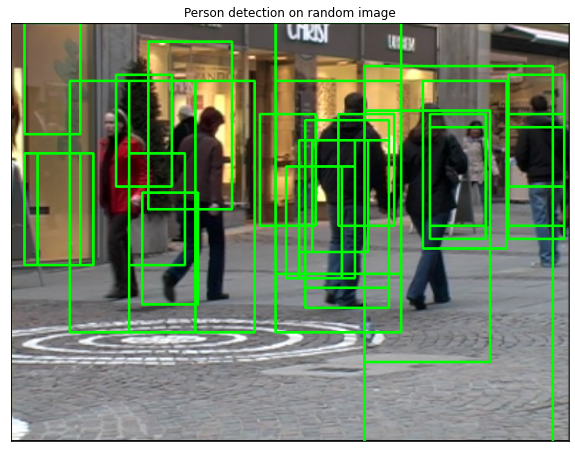

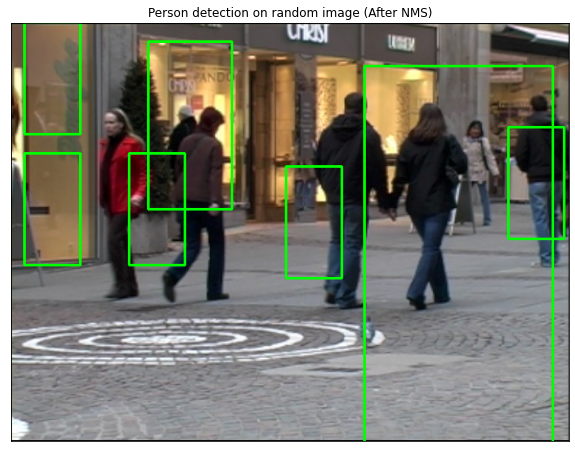

In [ ]:
detector(val_x[0], clf, pca)

## IOU

In [ ]:
def calculateIOU(bbox_1, bbox_2):
  '''
  bbox = [x,y,w,h]
  '''
  x1,y1,w1,h1 = bbox_1[0], bbox_1[1], bbox_1[2], bbox_1[3]
  x2,y2,w2,h2 = bbox_2[0], bbox_2[1], bbox_2[2], bbox_2[3]
  area_Bbox_1 = w1 * h1
  area_Bbox_2 = w2 * h2
  # Area of Intersection
  start_point_x, start_point_y  = max(x1, x2), max(y1, y2)
  end_point_x, end_point_y = min(x1+w1, x2+w2), min(y1+h1, y2+h2)
  x_dist = end_point_x - start_point_x
  y_dist = end_point_y - start_point_y
  areaIntersec = 0
  if x_dist > 0 and y_dist > 0:
    areaIntersec = x_dist * y_dist
  total_area = area_Bbox_1 + area_Bbox_2 - areaIntersec
  iou = areaIntersec / total_area
  return iou

def computeImageIOU(predicted_boxes, img_gt_boxes):
  # Prediction Boxes vs Ground True Boxes
  img_iou_list = []
  for predict_box in predicted_boxes:
    ped_box = np.array(predict_box).astype(float)
    ped_maxIOU = 0
    for gt_box in img_gt_boxes:
      #Calculate IOU GT_Box vs Predict_Box
      this_iou = calculateIOU(gt_box, ped_box)
      if this_iou > ped_maxIOU:
        ped_maxIOU = this_iou
    img_iou_list.append(ped_maxIOU)
  # Compute mean IOU for image
  avg_img_iou = sum(img_iou_list)/len(img_iou_list)
  return avg_img_iou

def plotDistributionIoU(iou_listValidSet, dataset_name, top_val=1):
  '''
  iou_listValidSet: List of IoUs of a validation set
  '''
  index_iou = [i for i in range(1, len(iou_listValidSet)+1)]
  plt.figure(figsize=(10,7))
  #plt.subplot(211)
  plt.title('IoU Distribution for {}'.format(dataset_name))
  plt.xlabel('Image#')
  plt.ylabel('IoU')
  plt.ylim(top=top_val)
  plt.bar(index_iou,iou_listValidSet)
  plt.tight_layout(2)
  plt.show()

## Detection

In [ ]:
def get_GTboxes(bbox, frame_i):
  gt_bboxes = []
  for _, x,y,w,h in bbox[frame_i]:
    gt_bboxes.append([x,y,w,h])
  return gt_bboxes

def get_color_imgs(vname, path, incr=1, total_imgs=50):
  '''
  incr: increment for loop
  '''
  color_imgs = []
  vpath = os.path.join(path, vname) #vname = folder name
  bbox = parse(os.path.join(vpath, 'gt.txt'))
  list_keys = [i for i in bbox.keys()]
  index_imgs = []
  gtBoxes_imgs = [] # Save gt_boxes for all images in dataset
  for i in list_keys[::incr]:
    img_name = "{:06n}".format(i) + ".jpg"
    img = cv.imread(vpath + "/imgs/" + img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    color_imgs.append(img)
    index_imgs.append(i)
    this_img_gtBoxes = get_GTboxes(bbox, i)
    gtBoxes_imgs.append(this_img_gtBoxes)
    if len(color_imgs) >= total_imgs:
      break
  return index_imgs, gtBoxes_imgs, color_imgs

In [ ]:
from imutils.object_detection import non_max_suppression
from skimage.transform import pyramid_gaussian
from skimage.feature import hog


def sliding_window(image, window_size, step_size):
  for y in range(0, image.shape[0], step_size[1]):
    for x in range(0, image.shape[1], step_size[0]):
      yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

def detector(img, clf, step=15, pca=None):
  img_temp = img.copy()
  im = cv.cvtColor(img_temp, cv.COLOR_RGB2GRAY) 
  window_size = (64, 128) # width, height
  step_size = (step, step) # step size for x, step size for y
  downscale = 1.5
  #List to store the detections
  detections = []
  scale = 0
  for im_scaled in pyramid_gaussian(im, downscale=downscale):
    if im_scaled.shape[0] < window_size[1] or im_scaled.shape[1] < window_size[0]:
      break
    for (x, y, im_window) in sliding_window(im_scaled, window_size, step_size):
      if im_window.shape[0] != window_size[1] or im_window.shape[1] != window_size[0]:
        continue
      # fd_temp = []
      im_window = cv.resize(im_window, (80,160), interpolation = cv.INTER_AREA)
      features = hog(im_window, orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2),block_norm='L1', visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)         
      # fd_temp.append(hist)
      # fd_temp = np.asarray(fd_temp)
      if pca != None:
        features = pca.transform(features.reshape(1, -1))
      pred = clf.predict(features)
      
      if pred[0] != '0':
        decision_value = clf.decision_function(features)
        if decision_value > 0.53:
          #print(decision_value)
          detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), clf.decision_function(features), int(window_size[0] * (downscale**scale)),int(window_size[1] * (downscale**scale))))    
    scale = scale + 1
  clone = img.copy()         
  rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
  sc = np.array([score[0] for (x, y, score, w, h) in detections])
  pick = non_max_suppression(rects, probs = sc, overlapThresh=0.15)
  # Normal Detections
  for x,y,_,w,h in detections:
    cv.rectangle(img_temp, (x, y), (x + w, y + h), (0, 255, 0), thickness = 2)
  # Non Max Detections
  for x,y,xx,yy in pick:
    cv.rectangle(clone, (x, y), (xx, yy), (0, 255, 0), thickness = 2)
  detect_list = [[x,y,w,h] for (x, y, _, w, h) in detections]
  pick_list = [[x,y,xx-x,yy-y] for (x,y,xx,yy) in pick]
  return detect_list, pick_list

## Data 1: TUD-Campus

### Detection

In [ ]:
#Loading variables
#Data1
#clf_0, val_color_0, pca_0
#img_basedir = '/content/drive/My Drive/McGill/Winter 2021/ECSE 415/415Project/'
hog_clf_path = img_basedir + 'hog_svm_pca_fold_0.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()
path = img_basedir +'MOT15/train/'
index_imgs, gtBoxes_imgs, val_color = get_color_imgs(vname='TUD-Campus', path=path, incr=1) # CHANGE dataset name
pca_path = img_basedir + 'pca_fold_0.pickle'
pca_store = open(pca_path, 'rb')
pca = pickle.load(pca_store)
pca_store.close()
val_x = np.asarray(val_color)
#Detecting...
# data_Detects_list = []
# print('Total Frames: ', len(val_x))
# for i in range(len(val_x)): # 50 frames
#   predict_boxes = []
#   # Get predictions. Step=60. (1m41s)
#   _, predict_boxes = detector(val_x[i],clf, step=60, pca=pca)
#   data_Detects_list.append(predict_boxes)
#   print('Detected: Frame', i)
# Saving detections
# len(data_Detects_list) == 50?
#data_detect_path = img_basedir +'detections/data1_detections.pickle' # CHANGE file name -> data#
#data_detect_store = open(data_detect_path, 'wb')
#pickle.dump(data_Detects_list, data_detect_store)
#data_detect_store.close()
#print('Data 1 Detections Saved.') # CHANGE print statement

# Previously saved code will now be loaded
detection_path = img_basedir + 'detections/data1_detections.pickle'
detection_store = open(detection_path, 'rb')
data_Detects_list = pickle.load(detection_store)
detection_store.close()

### IoU

Dataset: TUD-Campus
Total Frames:  50
Frame IoUs:  [0.19394789789333142, 0.2233442186560104, 0.30701059347389187, 0.15019777027706085, 0.28475808079079423, 0.382088007150072, 0.22653635068317865, 0.2455683191146853, 0.18637378641744742, 0.20904860215164933, 0.28227631421920185, 0.3302389927234125, 0.18284063671562903, 0.19078865141857268, 0.17222165940634182, 0.21659444930525615, 0.13465298142717497, 0.28221579060429514, 0.2454438148000318, 0.08119734364158986, 0.13051320601158323, 0.13198096651304808, 0.16385125408025525, 0.23652791135044132, 0.28293699921076876, 0.3014933628874772, 0.27406281365936047, 0.29439415247527095, 0.32865374509151013, 0.2909870326300332, 0.2032420705535083, 0.40725134841127675, 0.42631590725792223, 0.4337855920999396, 0.4776064118684304, 0.5706324881582614, 0.5249611460551205, 0.2366592285623207, 0.27119012532405684, 0.31345143450054136, 0.4642720326502885, 0.5844982202502157, 0.539471798050949, 0.37338364186613215, 0.17995485645378512, 0.13770693110947824, 

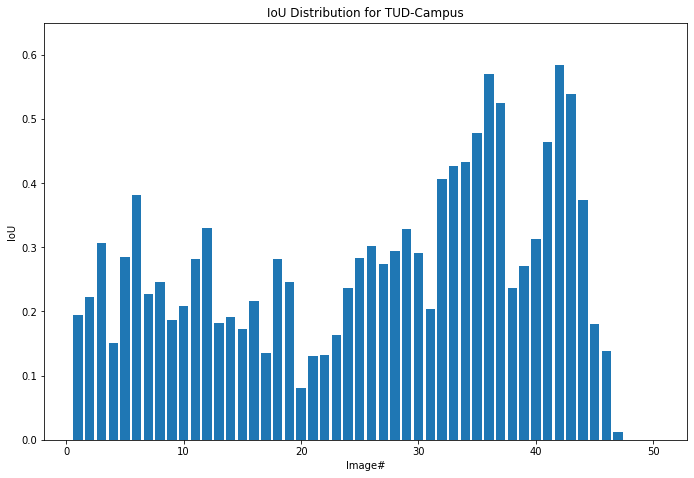

In [ ]:
# data_Detects_list, index_imgs, gtBoxes_imgs, val_color
list_IoUs_frames = []
for i in range(len(data_Detects_list)):
  frame_predicted_boxes = data_Detects_list[i]
  frame_gt_boxes = gtBoxes_imgs[i]
  frame_iou = computeImageIOU(frame_predicted_boxes, frame_gt_boxes)
  list_IoUs_frames.append(frame_iou)

print('Dataset: TUD-Campus') 
print('Total Frames: ', len(list_IoUs_frames)) 
print('Frame IoUs: ', list_IoUs_frames)
print('Best IoU: ', max(list_IoUs_frames))
print('Mean IoU: ', sum(list_IoUs_frames)/len(list_IoUs_frames))

plotDistributionIoU(list_IoUs_frames, 'TUD-Campus',0.65)

## Data 2: TUD-Stadtmitte

### Detection

In [ ]:
#Loading variables
#Data2
#clf_1, val_color_1, pca_1
#img_basedir = '/content/drive/My Drive/McGill/Winter 2021/ECSE 415/415Project/'
hog_clf_path = img_basedir + 'hog_svm_pca_fold_1.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()
path = img_basedir +'MOT15/train/'
index_imgs, gtBoxes_imgs, val_color = get_color_imgs(vname='TUD-Stadtmitte', path=path, incr=1)
pca_path = img_basedir + 'pca_fold_1.pickle'
pca_store = open(pca_path, 'rb')
pca = pickle.load(pca_store)
pca_store.close()
val_x = np.asarray(val_color)
#Detecting...
# data_Detects_list = []
# print('Total Frames: ', len(val_x))
# for i in range(len(val_x)): # 50 frames
#   predict_boxes = []
#   # Get predictions. Step=60. (1m41s)
#   _, predict_boxes = detector(val_x[i],clf, step=60, pca=pca)
#   data_Detects_list.append(predict_boxes)
#   print('Detected: Frame', i)
# Saving detections
#len(data4_Detects_list) == 50?
# data_detect_path = img_basedir +'detections/data2_detections.pickle' # CHANGE file name -> data#
# data_detect_store = open(data_detect_path, 'wb')
# pickle.dump(data_Detects_list, data_detect_store)
# data_detect_store.close()

# Previously saved code will now be loaded
detection_path = img_basedir + 'detections/data2_detections.pickle'
detection_store = open(detection_path, 'rb')
data_Detects_list = pickle.load(detection_store)
detection_store.close()

### IoU

Dataset: TUD-Stadtmitte
Total Frames:  50
Frame IoUs:  [0.26009813567199813, 0.2583471407712364, 0.2962616780819337, 0.3395973411229541, 0.4689759295100915, 0.4865025107058069, 0.4163262023982063, 0.4067359755157719, 0.39829801306513984, 0.3289191807222998, 0.3153507629340797, 0.3946786015837422, 0.28550090384094656, 0.27643422777763443, 0.007747817529104267, 0.28499164225537266, 0.3193216147542291, 0.26848792442700326, 0.25889938936165385, 0.2517857427500166, 0.2205983859465307, 0.28448719707934317, 0.14179577396053206, 0.14225247465533974, 0.14270925774493612, 0.2590116701108792, 0.12079262588175489, 0.21162521039309415, 0.3589287388088342, 0.39772962890913677, 0.21903255488999915, 0.3571455945174554, 0.4742465770333628, 0.3147470502293907, 0.2638044557597219, 0.32707985812214085, 0.32768407346359246, 0.47896658394669855, 0.3285626506572716, 0.32836699913198913, 0.4533696013303275, 0.45054006433517924, 0.27872549089523513, 0.36813616565222146, 0.36770437979032056, 0.2963831132191691,

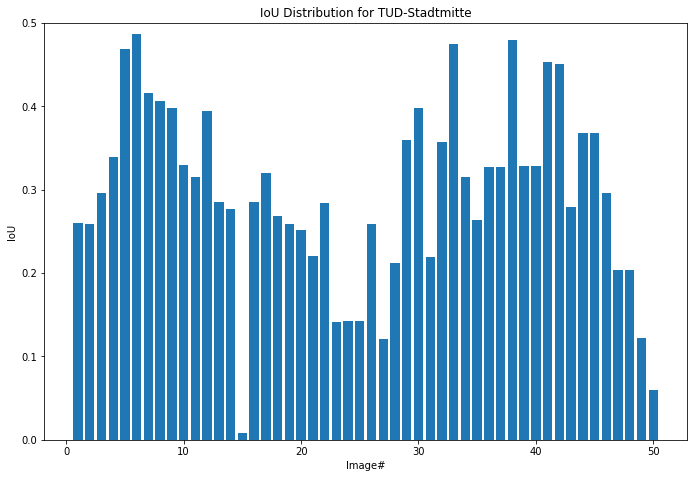

In [ ]:
list_IoUs_frames = []
for i in range(len(data_Detects_list)): 
  frame_predicted_boxes = data_Detects_list[i]
  frame_gt_boxes = gtBoxes_imgs[i]
  frame_iou = computeImageIOU(frame_predicted_boxes, frame_gt_boxes)
  list_IoUs_frames.append(frame_iou)

print('Dataset: TUD-Stadtmitte')
print('Total Frames: ', len(list_IoUs_frames))
print('Frame IoUs: ', list_IoUs_frames)
print('Best IoU: ', max(list_IoUs_frames))
print('Mean IoU: ', sum(list_IoUs_frames)/len(list_IoUs_frames))

plotDistributionIoU(list_IoUs_frames, 'TUD-Stadtmitte',0.50)

## Data 3: ADL-Rundle-6

### Detection

In [ ]:
#Loading variables
#Data3
#clf_2, val_color_2, pca_2
#img_basedir = '/content/drive/My Drive/McGill/Winter 2021/ECSE 415/415Project/'
hog_clf_path = img_basedir + 'hogs/hog_svm_pca_fold_2.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()
path = img_basedir +'MOT15/train/'
index_imgs, gtBoxes_imgs, val_color = get_color_imgs(vname='ADL-Rundle-6', path=path, incr=5) 
pca_path = img_basedir + 'pca_fold_2.pickle'
pca_store = open(pca_path, 'rb')
pca = pickle.load(pca_store)
pca_store.close()
val_x = np.asarray(val_color)
#Detecting...
# data_Detects_list = []
# print('Total Frames: ', len(val_x))
# for i in range(len(val_x)): # 50 frames
#   predict_boxes = []
#   # Get predictions. Step=60. (1m41s)
#   _, predict_boxes = detector(val_x[i],clf, step=60, pca=pca)
#   data_Detects_list.append(predict_boxes)
#   print('Detected: Frame', i)
# Saving detections
# len(data4_Detects_list) == 50?
# data_detect_path = img_basedir +'detections/data3_detections.pickle' # CHANGE file name -> data#
# data_detect_store = open(data_detect_path, 'wb')
# pickle.dump(data_Detects_list, data_detect_store)
# data_detect_store.close()
#print('Data 3 Detections Saved.') # CHANGE print statement

# Previously saved code will now be loaded
detection_path = img_basedir + 'detections/data3_detections.pickle'
detection_store = open(detection_path, 'rb')
data_Detects_list = pickle.load(detection_store)
detection_store.close()

### IoU

Dataset: ADL-Rundle-6
Total Frames:  50
Frame IoUs:  [0.03379080161572171, 0.022645028901385207, 0.04605309814824692, 0.019800610635994108, 0.021466571728489175, 0.08517980203289532, 0.09126426426465577, 0.046855340989041594, 0.027663756338195587, 0.032354649392242196, 0.12291404988800365, 0.06685667074879997, 0.07524644462389359, 0.11232137236532166, 0.11616914850100715, 0.09734232316486263, 0.10303510243805156, 0.0652352442831704, 0.08643695889121264, 0.06715592597227776, 0.06596051315297395, 0.05602921770962929, 0.07498875434700647, 0.15759363812023186, 0.0844247179172857, 0.1046663460274293, 0.06967553999141085, 0.06141430930911393, 0.1759803200191514, 0.11572407483791947, 0.10179652157926185, 0.09811743581351305, 0.08072515074575227, 0.09260535449732034, 0.21061826050658583, 0.18185462646548434, 0.09753717612444388, 0.08969900443339861, 0.09583218573162747, 0.0913856350879264, 0.0693404639323127, 0.0784874307706175, 0.12448426356897041, 0.12626653598584553, 0.09988467530727667, 0.

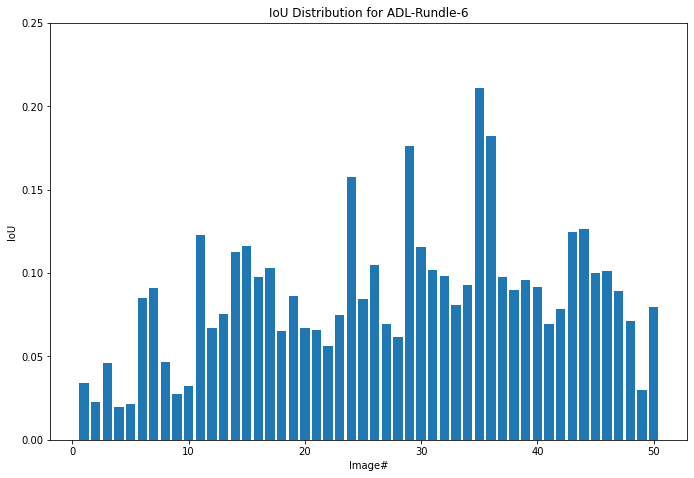

In [ ]:
# data_Detects_list, index_imgs, gtBoxes_imgs, val_color
list_IoUs_frames = []
for i in range(len(data_Detects_list)): #CHANGE detect_list
  frame_predicted_boxes = data_Detects_list[i]
  frame_gt_boxes = gtBoxes_imgs[i]
  frame_iou = computeImageIOU(frame_predicted_boxes, frame_gt_boxes)
  list_IoUs_frames.append(frame_iou)

print('Dataset: ADL-Rundle-6') # CHANGE dataset
print('Total Frames: ', len(list_IoUs_frames)) #50
print('Frame IoUs: ', list_IoUs_frames)
print('Best IoU: ', max(list_IoUs_frames))
print('Mean IoU: ', sum(list_IoUs_frames)/len(list_IoUs_frames))

plotDistributionIoU(list_IoUs_frames, 'ADL-Rundle-6',0.25)

## Data 4: ADL-Rundle-6

### Detection

In [ ]:
#Loading variables
#Data4
#clf_3, val_color_3, pca_3
hog_clf_path = img_basedir + 'hogs/hog_svm_pca_fold_3.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf_3 = pickle.load(hog_clf_store)
hog_clf_store.close()
path = img_basedir +'MOT15/train/'
index_imgs, gtBoxes_imgs, val_color = get_color_imgs(vname='ADL-Rundle-8', path=path, incr=5)
pca_path = img_basedir + 'pca_fold_3.pickle'
pca_store = open(pca_path, 'rb')
pca_3 = pickle.load(pca_store)
pca_store.close()
val_x = np.asarray(val_color)
#Detecting...
# data4_Detects_list = [] # list of detections for all images in dataset: list(list_predict_boxes of image)
# print('Total Frames: ', len(val_x))
# for i in range(len(val_x)): # 50 frames
#   predict_boxes = [] # detections for image i
#   # Get predictions. Step=60. (1m41s)
#   _, predict_boxes = detector(val_x[i],clf_3, step=60, pca=pca_3)
#   data4_Detects_list.append(predict_boxes)
#   print('Detected: Frame', i)
# Saving detections
# len(data4_Detects_list) == 50?
#data4_detect_path = img_basedir +'detections/data4_detections.pickle'
#data4_detect_store = open(data4_detect_path, 'wb')
#pickle.dump(data4_Detects_list, data4_detect_store)
#data4_detect_store.close()
#print('Data 4 Detections Saved.')

# Previously saved code will now be loaded
detection_path = img_basedir + 'detections/data4_detections.pickle'
detection_store = open(detection_path, 'rb')
data_Detects_list = pickle.load(detection_store)
detection_store.close()

### IoU

Dataset: ADL-Rundle-8
Total Frames:  50
Frame IoUs:  [0.0, 0.07330264394825256, 0.06447583935868517, 0.002440799517165477, 0.08938039991382347, 0.09794913086723821, 0.06801844742740834, 0.0, 0.026270009189953685, 0.09738609234077945, 0.11081020513893809, 0.04020942408376964, 0.028607691842778574, 0.01694898464586429, 0.019926256558300326, 0.019284169714982473, 0.005119537526944934, 0.016311872689573993, 0.07451204338764188, 0.0013667992047713719, 0.0, 0.009983967935871743, 0.004154759183051364, 0.004616399092279293, 0.037846538495204016, 0.06859264872005755, 0.059581146443029115, 0.07930523979433252, 0.04782477596369132, 0.027588440596255735, 0.03236568853233003, 0.0770180477028838, 0.08011360492230701, 0.0214999952012203, 0.05642153634086945, 0.015324235453227225, 0.08024263208411882, 0.05352538590678566, 0.049025008721793766, 0.05773861009716723, 0.021424162509331705, 0.02408789238485034, 0.018288299060023702, 0.013922851942854876, 0.022924423859737992, 0.10336840963795359, 0.0422483

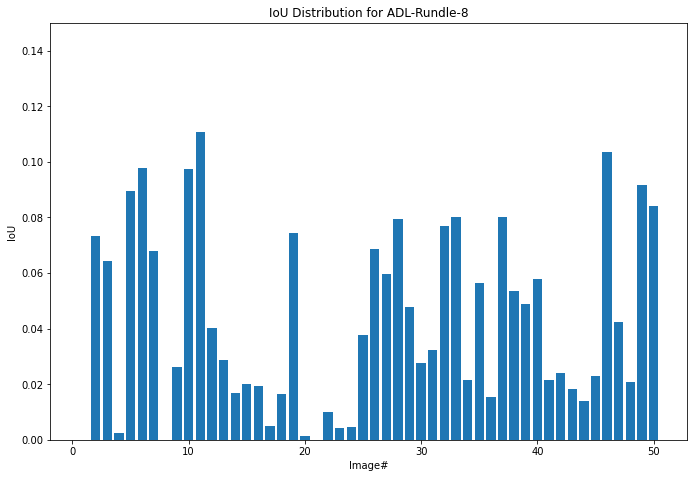

In [ ]:
list_IoUs_frames = []
for i in range(len(data_Detects_list)):
  frame_predicted_boxes = data_Detects_list[i]
  frame_gt_boxes = gtBoxes_imgs[i]
  frame_iou = computeImageIOU(frame_predicted_boxes, frame_gt_boxes)
  list_IoUs_frames.append(frame_iou)

print('Dataset: ADL-Rundle-8')
print('Total Frames: ', len(list_IoUs_frames)) #50
print('Frame IoUs: ', list_IoUs_frames)
print('Best IoU: ', max(list_IoUs_frames))
print('Mean IoU: ', sum(list_IoUs_frames)/len(list_IoUs_frames))

plotDistributionIoU(list_IoUs_frames, 'ADL-Rundle-8',0.15)

## Data 5: Venice-2

### Detection

In [ ]:
#Loading variables
#Data5
#clf_4, val_color_4, pca_4
img_basedir = '/content/drive/My Drive/McGill/Winter 2021/ECSE 415/415Project/'
hog_clf_path = img_basedir + 'hogs/hog_svm_pca_fold_4.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()
path = img_basedir +'MOT15/train/'
index_imgs, gtBoxes_imgs, val_color = get_color_imgs(vname='Venice-2', path=path, incr=5)
pca_path = img_basedir + 'pca_fold_4.pickle'
pca_store = open(pca_path, 'rb')
pca = pickle.load(pca_store)
pca_store.close()
val_x = np.asarray(val_color)
#Detecting...
# data_Detects_list = [] # list of detections for all images in dataset: list(list_predict_boxes of image)
# print('Total Frames: ', len(val_x))
# for i in range(len(val_x)): # 50 frames
#   predict_boxes = [] # detections for image i
#   # Get predictions. Step=60. (1m41s)
#   _, predict_boxes = detector(val_x[i], clf, step=60, pca=pca)
#   data5_Detects_list.append(predict_boxes)
#   print('Detected: Frame', i)
# Saving detections
# len(data5_Detects_list) == 50?
#data5_detect_path = img_basedir +'detections/data5_detections.pickle'
#data5_detect_store = open(data5_detect_path, 'wb')
#pickle.dump(data5_Detects_list, data5_detect_store)
#data5_detect_store.close()
#print('Data 5 Detections Saved.')

# Previously saved code will now be loaded
detection_path = img_basedir + 'detections/data5_detections.pickle'
detection_store = open(detection_path, 'rb')
data_Detects_list = pickle.load(detection_store)
detection_store.close()

### IoU

Dataset: Venice-2
Total Frames:  50
Frame IoUs:  [0.11567534158080701, 0.07011881057189283, 0.10503137826955428, 0.07094634175574137, 0.063480632971051, 0.06514153279478668, 0.08786276083090491, 0.04737502201735217, 0.04289624549535115, 0.025623898032862795, 0.042709134249731134, 0.0436930222446969, 0.05027510914881255, 0.0713700995856084, 0.06996953847576434, 0.0665591319698818, 0.06241867891816712, 0.04813694379334562, 0.05480642094716633, 0.022858370532381263, 0.05923106860587103, 0.041836686962345104, 0.08134721912837523, 0.05993204557237073, 0.08739805191700845, 0.05909284719112307, 0.06512253875810081, 0.08504218774810698, 0.07505705883055122, 0.06956199553774277, 0.09956810862837032, 0.11430304728811726, 0.09737583668182247, 0.07533599288387355, 0.054771399921146234, 0.05829688543491977, 0.024783295437272503, 0.05419433207942696, 0.09282651151930268, 0.09984728188727036, 0.07518650570728044, 0.1043199513656324, 0.04407449861854627, 0.071581935318491, 0.07977330662705683, 0.09870

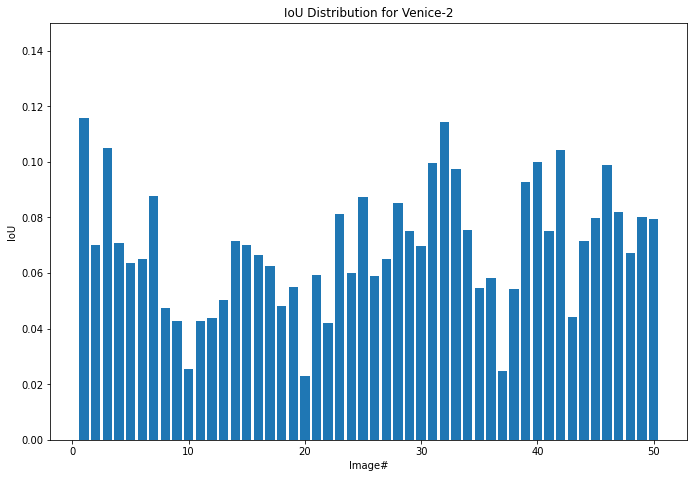

In [ ]:
list_IoUs_frames = []
for i in range(len(data_Detects_list)):
  frame_predicted_boxes = data_Detects_list[i]
  frame_gt_boxes = gtBoxes_imgs[i]
  frame_iou = computeImageIOU(frame_predicted_boxes, frame_gt_boxes)
  list_IoUs_frames.append(frame_iou)

print('Dataset: Venice-2')
print('Total Frames: ', len(list_IoUs_frames)) #50
print('Frame IoUs: ', list_IoUs_frames)
print('Best IoU: ', max(list_IoUs_frames))
print('Mean IoU: ', sum(list_IoUs_frames)/len(list_IoUs_frames))

#Plot Distribution
plotDistributionIoU(list_IoUs_frames, 'Venice-2', top_val=0.15)

# Tracking

## Utils

In [ ]:
class ImgGetter:
  def __init__(self, dataset, is_train=True):
    self.frame_no = 1
    setype = 'train' if is_train else 'test'
    self.path = '{}MOT15/{}/{}/imgs'.format(img_basedir, setype, dataset)
    self.dataset = dataset
    self.total_frames = len(os.listdir(self.path))

  def get_img(self, color='RGB'):
    if self.frame_no > self.total_frames:
      return None
    img = cv.imread(self.path + "/{:06n}".format(self.frame_no) + ".jpg")
    if color == 'RGB':
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    elif color == 'gray':
      img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    self.frame_no += 1
    return img


def get_gt_bbox(bboxes, frame_no, pid):
  bbox = [b for b in bboxes[frame_no] if b[0] == pid]
  if len(bbox) < 1:
    # the person not presents in the frame
    return None

  return tuple([b for b in bboxes[frame_no] if b[0] == pid][0][1:].astype(int))


# plot the frame iou
def plot_iou_distribution(frame_ious, dataset):
  ious_key_sorted = sorted(frame_ious, key=frame_ious.get, reverse=True)
  values_sorted = [frame_ious[k] for k in ious_key_sorted]
  position = range(len(ious_key_sorted))
  plt.figure(figsize=(20,10))
  plt.bar(position, values_sorted, width=0.8)
  plt.xticks(position, ious_key_sorted, rotation='vertical')
  plt.title('{} Frame IOU Distribution'.format(dataset))
  plt.xlabel('Frame No.')
  plt.ylabel('IOU')
  plt.show()

### Init Detector

Initialise the detector with the configuration from previous steps and get the bbox for the first frame

In [ ]:
# load the best classifier
hog_clf_path = img_basedir + 'hog_svm_pca_fold_1.pickle'
hog_clf_store = open(hog_clf_path, 'rb')
clf = pickle.load(hog_clf_store)
hog_clf_store.close()

# pca
# pca = PCA(n_components=4000).fit(np.asarray(x_hog_1 + x_hog_3 + x_hog_4 + x_hog_5))
pca_path = '/content/pca_5_fold.pickle'
pca_store = open(pca_path, 'rb')
pca = pickle.load(pca_store)

### Match Prediction Box with gt Box

In [ ]:
# if the same as in the IOU, this can be deleted
def get_gt_bboxes(setname, img_number):
  '''
  Gets GT Boxes for an image in Training Set
  setname = 'Campus' | 'Stadtmitte'
  '''
  # img_number is without the previous 0s
  pid_bbox_dict = {}
  bboxes = parse(os.path.join('{}MOT15/train/{}'.format(img_basedir, setname), 'gt.txt'))
  for pid, x,y,w,h in bboxes[img_number]:
      pid_bbox_dict[pid] = [x,y,w,h]
  
  return pid_bbox_dict
  

def computeImageIOU(setname, img_number, non_max_boxes):
  path = img_basedir + 'MOT15/train/TUD-{}/'.format(setname)
  img_name = "{:06n}".format(img_number) + ".jpg"
  # Read Image
  image_this = cv.imread(path + "imgs/" + img_name)
  # Get Ground True Boxes
  pid_bbox_dict = get_gt_bboxes(setname, img_number)

  # Prediction Boxes vs Ground True Boxes
  img_iou_list = []
  pid_prediction_dict = {}
  for predict_box in non_max_boxes:
    ped_box = np.array(predict_box).astype(float)
    ped_maxIOU = 0
    best_match = []
    for pid, gt_box in pid_bbox_dict.items():
      #Calculate IOU GT_Box vs Predict_Box
      this_iou = calculateIOU(gt_box, ped_box)
      if this_iou > ped_maxIOU:
        ped_maxIOU = this_iou
        best_match = [pid, ped_box]
    img_iou_list.append(ped_maxIOU)
    pid_prediction_dict[best_match[0]] = best_match[1]
  # Compute mean IOU for image
  avg_img_iou = sum(img_iou_list)/len(img_iou_list)
  return avg_img_iou, pid_prediction_dict

## Optical Flow (Lucas Kanade Template Traker)

reference: 
https://github.com/anubhavparas/lucas-kanade-tracker/blob/master/Code/lucaskanade.py

In [ ]:
class ImgGetter:
  def __init__(self, dataset):
    self.frame_no = 1
    self.path = '{}MOT15/train/{}/imgs'.format(img_basedir, dataset)
    self.dataset = dataset
    self.total_frames = len(os.listdir(self.path))

  def get_img(self, color='RGB'):
    if self.frame_no > self.total_frames:
      return None
    img = cv.imread(self.path + "/{:06n}".format(self.frame_no) + ".jpg")
    if color == 'RGB':
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    elif color == 'gray':
      img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    self.frame_no += 1
    return img


def get_gt_bbox(bboxes, frame_no, pid):
  bbox = [b for b in bboxes[frame_no] if b[0] == pid]
  if len(bbox) < 1:
    # the person not presents in the frame
    return None

  return tuple([b for b in bboxes[frame_no] if b[0] == pid][0][1:].astype(int))

### KLT Implementation

In [ ]:
def get_warped_patch(bbox, warp, frame):
  x, y, w, h = bbox
  warped_frame = cv.warpAffine(frame, warp, (frame.shape[1], frame.shape[0]), flags=cv.INTER_CUBIC+cv.WARP_INVERSE_MAP)
  patch = warped_frame[y:y+h, x:x+w]
  return patch


def get_jacobian(x_shape, y_shape):
    # get jacobian of the template size.
    x = np.array(range(x_shape))
    y = np.array(range(y_shape))
    x, y = np.meshgrid(x, y) 
    ones = np.ones((y_shape, x_shape))
    zeros = np.zeros((y_shape, x_shape))

    row1 = np.stack((x, zeros, y, zeros, ones, zeros), axis=2)
    row2 = np.stack((zeros, x, zeros, y, zeros, ones), axis=2)
    jacob = np.stack((row1, row2), axis=2)

    return jacob


def get_dIW(jacobian, dI):
  dI = np.expand_dims((dI), axis=2)
  steepest_descents = np.matmul(dI, jacobian)
  steepest_descents_t = np.transpose(steepest_descents, (0, 1, 3, 2))
  return steepest_descents, steepest_descents_t


def get_warp_from_p(p):
  return np.array([[1+p[0], p[1], p[4]], [p[2], 1+p[3], p[5]]])


def update_warp(bbox, p, current_frame, template):
  i = 0
  dp_norm = np.inf
  thres = 0.001
  max_iter = 50
  rows, cols = template.shape
  while dp_norm >= thres and i < max_iter:
    warp = get_warp_from_p(p)
    warped_img = get_warped_patch(bbox, warp, current_frame)
    error = (template.astype(int) - warped_img.astype(int))

    Ix = cv.Sobel(current_frame, cv.CV_64F, 1, 0, ksize=5)
    Ix_warped = get_warped_patch(bbox, warp, Ix)
    Iy = cv.Sobel(current_frame, cv.CV_64F, 0, 1, ksize=5)
    Iy_warped = get_warped_patch(bbox, warp, Iy)
    dI = np.stack((Ix_warped, Iy_warped), axis=2)

    jacobian = get_jacobian(cols, rows)
    dIW, dIW_t = get_dIW(jacobian, dI)

    hessian = np.matmul(dIW_t, dIW).sum((0,1))
    # add eps to avoid singular matrix
    hessian = hessian + np.identity(6)*1e-6

    temp = (dIW_t * error.reshape(error.shape[0], error.shape[1], 1, 1)).sum((0,1))
    dp = np.matmul(np.linalg.inv(hessian), temp).reshape(-1)
    dp_norm = np.linalg.norm(dp)
    p += dp
    i += 1
  
  # debug code:
  # print('dp_norm', dp_norm)
  # print('p', p)
  # plt.figure()
  # plt.subplot(121), plt.imshow(error, cmap='gray')
  # plt.subplot(122), plt.imshow(warped_img, cmap='gray')
  # plt.show()
  return p


def pyr_KLT(bbox, p, current_frame, template, num_layer):
  # sample down the current frame
  template = cv.GaussianBlur(template, (5, 5), 5) 
  for i in range(num_layer):
    current_frame = cv.pyrDown(current_frame)
    template = cv.pyrDown(template)

  # scale down the bbox
  bbox = np.array([bbox[0]/(2**num_layer), 
                   bbox[1]/(2**num_layer), 
                   template.shape[1], 
                   template.shape[0]]).astype(np.int)  

  for i in range(max(1, num_layer)):
    p = update_warp(bbox, p, current_frame, template)
    current_frame = cv.pyrUp(current_frame)
    template = cv.pyrUp(template)
    bbox = (bbox * 2).astype(np.int)
  
  return p

### Tracker Utils

In [ ]:
def check_bbox_in_range(bbox, frame):
  rows, cols = frame.shape
  if np.any(bbox < 0) or np.any(bbox[:, 0]>cols) or np.any(bbox[:, 1]>rows):
    return False
  return True


def draw_bbox(frame, bbox_vertices):
  rows, cols = frame.shape[0], frame.shape[1]

  bbox_vertices = np.where(bbox_vertices[:, :] < 0, 0, bbox_vertices)
  col0 = np.where(bbox_vertices[:, 0] > cols, cols-1, bbox_vertices[:, 0])
  col1 = np.where(bbox_vertices[:, 1] > rows, rows-1, bbox_vertices[:, 1])
  bbox_vertices = np.hstack((col0.reshape(-1,1), col1.reshape(-1,1)))
  # print(bbox_vertices)

  # bbox_vertices: array of tuples
  ul, ur, ll, lr = list(map(lambda p: tuple(p), bbox_vertices.astype(int)))
  frame = frame.copy()
  cv.line(frame, ul, ur, (0,0,255),4)
  cv.line(frame, ul, ll, (0,0,255),4)
  cv.line(frame, ll, lr, (0,0,255),4)
  cv.line(frame, ur, lr, (0,0,255),4)
  return frame


def warp_point(warp, points):
  # points shape: n*2
  num_points = points.shape[0]
  points = np.hstack((points, np.ones((num_points, 1)))) 
  warped_points = np.matmul(warp, points.T).T
  return warped_points
  

class KLT_Tracker:
  def __init__(self, pid, bbox, frame):
    self.bbox = bbox
    self.pid = pid
    self.template = frame[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    self.p = np.zeros(6)

  def track_and_evaluate(self, frame_no, current_frame, output_img, gt, pyr_level):
    # update p and get new warp matrix
    bbox = self.bbox
    self.p = pyr_KLT(bbox, self.p, current_frame, self.template, pyr_level)
    warp = get_warp_from_p(self.p)
    # print('warp',warp)
    
    # the four corners of the bbox: ul, ur, ll, lr
    points = np.array([[bbox[0], bbox[1]], 
                      [bbox[0] + bbox[2], bbox[1]], 
                      [bbox[0], bbox[1] + bbox[3]], 
                      [bbox[0] + bbox[2], bbox[1] + bbox[3]]])
    warped_points = warp_point(warp, points)
    output_img = draw_bbox(output_img, warped_points)

    # compute iou
    iou = 0
    failure = False
    if gt is not None:
      gt_bbox = get_gt_bbox(gt, frame_no, self.pid)
      if not check_bbox_in_range(warped_points, current_frame):
        # track failure, no bbox predicted
        iou = 1 if gt_bbox is None else 0
        failure = True
        return output_img, iou, failure

      tracked_bbox = np.array([warped_points[0][0], 
                              warped_points[0][1], 
                              warped_points[3][0] - warped_points[0][0], 
                              warped_points[3][1] - warped_points[0][1]] )
      iou = calculateIOU(gt_bbox, tracked_bbox) if gt_bbox is not None else 0
      failure = True if iou == 0 else False

    return output_img, iou, failure

### Code to Run

In [ ]:
def KLT_track_and_save(trackers, getter, gt, max_frame, pyr_level, reset_func=None):  
  ims = []
  iou_avg = 0
  frame_ious = {}
  fig = plt.figure()
  failure = 0
  while True:
    # print('current frame: ', getter.frame_no) 
    color_img = getter.get_img('RGB')
     
    if color_img is None or getter.frame_no > max_frame:
      break

    if failure >= 10 and reset_func is not None:
      failure = 0
      trackers = reset_func(trackers)


    output_img = color_img.copy()
    current_frame = cv.cvtColor(color_img, cv.COLOR_RGB2GRAY)
    frame_iou = 0
    for tracker in trackers:
      output_img, iou, is_failure = tracker.track_and_evaluate(getter.frame_no-1, current_frame, output_img, gt, pyr_level)
      iou_avg += iou
      frame_iou += iou
      if is_failure:
        failure += 1
      else:
        failure = 0
    
    # save the result
    im = plt.imshow(output_img, animated=True)
    ims.append([im])

    if gt is not None:
      # print frame_no and frame_iou
      frame_iou = frame_iou / len(trackers)
      frame_ious[getter.frame_no - 1] = frame_iou
      print('frame_no: ', getter.frame_no - 1, " frame_iou: ", frame_iou)

  if gt is not None:
    print('IOU Evaluation: ', iou_avg / (len(trackers) * getter.total_frames))
  print('Waiting for display')
  ani = animation.ArtistAnimation(fig, ims, interval=1000/30, blit=True, repeat_delay=1000)
  ani.save('/content/{}.mp4'.format(getter.dataset))
  plt.close()
  return frame_ious


### Track with Detection Result

In [ ]:
def create_trackers_train(rectangle_box, getter, old_trackers, init_frame):
  trackers = []
  i = 0
  # reset 
  _, pid_bbox = computeImageIOU(getter.dataset, 1, rectangle_box)
  if old_trackers is not None:
    for old_t in old_trackers:
      opid = old_t.pid
      if opid in pid_bbox.keys():
        trackers.append(KLT_Tracker(opid, pid_bbox[opid].astype(int),init_frame))
        i += 1
        del pid_bbox[opid]

  for pid, bbox in pid_bbox.items():
    if i >= 3:
      break
    print(pid, bbox)
    tracker = KLT_Tracker(pid, bbox.astype(int),init_frame)
    trackers.append(tracker)
    i += 1
  return trackers


def create_trackers_test(rectangle_box, init_frame):
  trackers = []
  i = 0
  for x,y,xx,yy in rectangle_box:
    if i >= 3:
      break
    trackers.append(KLT_Tracker(i, np.array([x, y, xx-x, yy-y]).astype(int),init_frame))
    i += 1
  return trackers


def reset_tracker(getter, clf, pca, old_trackers=None, is_train_set=True):
  init_frame = getter.get_img('RGB')
  non_max_bbox = detector(init_frame, clf, pca, False)
  init_frame = cv.cvtColor(init_frame, cv.COLOR_RGB2GRAY)
  # init tracker with the first 3 bbox
  if is_train_set:
    trackers = create_trackers_train(non_max_bbox, getter, old_trackers, init_frame)
  else:
    trackers = create_trackers_test(non_max_bbox, init_frame)

  return trackers


def klt_detect_and_track(getter, clf, pca, max_iter, pyr_level, is_train=True):
  trackers = reset_tracker(getter, clf, pca, None, is_train)
  reset = lambda ts: reset_tracker(getter, clf, pca, ts, is_train)

  gt = None
  if is_train:
    gt  = parse(os.path.join('{}MOT15/train/{}'.format(img_basedir, getter.dataset), 'gt.txt'))
  return KLT_track_and_save(trackers, getter, gt, max_iter, pyr_level, reset)

5.0 [405.  50. 621. 482.]
2.0 [ 50.   0. 266. 432.]
4.0 [345. 135. 409. 263.]
frame_no:  2  frame_iou:  0.048619420778522826
frame_no:  3  frame_iou:  0.048466418825362644
frame_no:  4  frame_iou:  0.04840094447587953
frame_no:  5  frame_iou:  0.04794311755540954
frame_no:  6  frame_iou:  0.047825985441815023
frame_no:  7  frame_iou:  0.04770665683972572
frame_no:  8  frame_iou:  0.04805019032824145
frame_no:  9  frame_iou:  0.0
frame_no:  10  frame_iou:  0.0
frame_no:  11  frame_iou:  0.0
frame_no:  13  frame_iou:  0.12427390454067984
frame_no:  14  frame_iou:  0.12323122087735332
frame_no:  15  frame_iou:  0.12293341760797649
frame_no:  16  frame_iou:  0.1233152073557035
frame_no:  17  frame_iou:  0.12215949049713731
frame_no:  18  frame_iou:  0.12210261272682336
frame_no:  19  frame_iou:  0.12097594565344261
frame_no:  20  frame_iou:  0.11888225000928798
frame_no:  21  frame_iou:  0.11543118184731149
frame_no:  22  frame_iou:  0.11227496700885108
frame_no:  23  frame_iou:  0.1089269

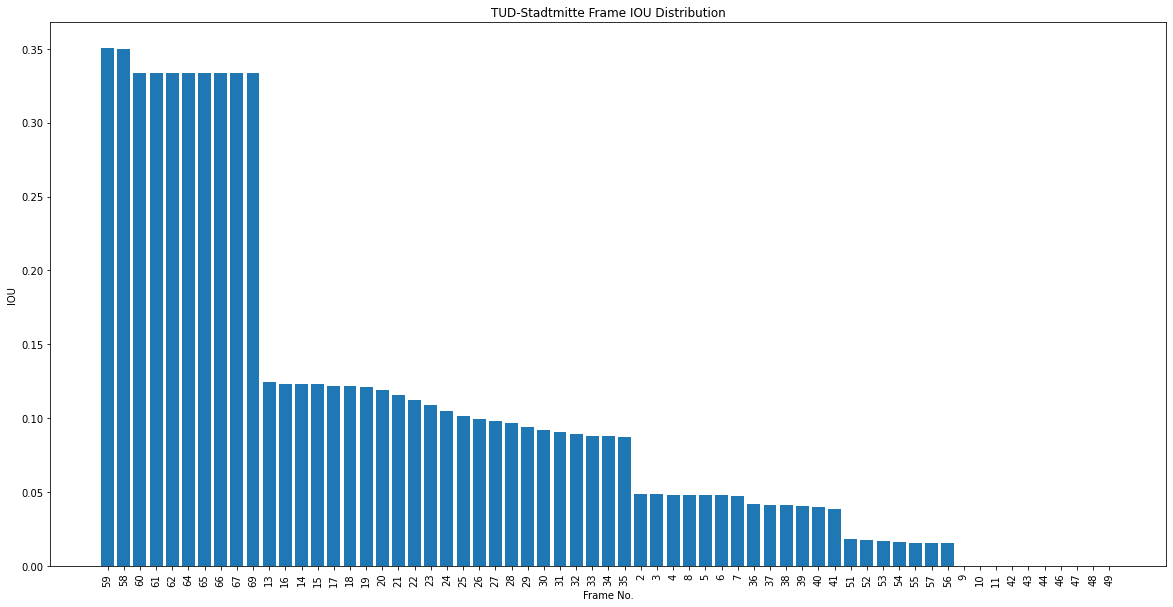

In [ ]:
getter = ImgGetter('TUD-Stadtmitte')
frame_ious = klt_detect_and_track(getter, clf, pca, 70, 2)
plot_iou_distribution(frame_ious, 'TUD-Stadtmitte')

In [ ]:
# run on test set
dataset = 'TUD-Crossing'
getter = ImgGetter(dataset, False)
kcf_frame_ious = klt_detect_and_track(getter, clf, pca, 70, 1, False)

Waiting for display


## KCF Tracker

with reference from the tutorial 12

In [ ]:
class Tracker:
  # a wrapperclass of cv2's tracker
  def __init__(self, bbox, pid, frame, bbox_color):
    self.pid = pid
    self.tracker = cv.TrackerKCF_create()
    self.tracker.init(frame, bbox)
    self.color = bbox_color

  def update(self, frame):
    ok, bbox = self.tracker.update(frame)
    if not ok:
      return -1, -1, None

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    return p1, p2, bbox


def track_and_save(trackers, getter, bboxes, max_frame, reset_func=None, print_frame_iou=True):
  fig = plt.figure()
  ims = []
  iou_avg = 0
  frame_ious = {}
  failure = 0
  while True:
    if failure >= 10 and reset_func is not None:
      failure = 0
      trackers = reset_func(trackers)

    # Read a new frame
    frame = getter.get_img()
    if frame is None or getter.frame_no > max_frame:
      break

    frame_copy = frame.copy()
    frame_iou = 0
    for tracker in trackers:      
      p1, p2, bbox = tracker.update(frame)

      # run on train set, calculate iou
      if bboxes is not None:
        gt_bbox = get_gt_bbox(bboxes, getter.frame_no - 1, tracker.pid)
        if p1 == -1 or p2 == -1:
          # track failure, no bbox predicted
          iou = 1 if gt_bbox is None else 0
          failure += 1
          continue

        iou = calculateIOU(gt_bbox, bbox) if gt_bbox is not None else 0
        if iou == 0:
          failure += 1
        else:
          failure = 0
        
        iou_avg += iou
        frame_iou += iou
        cv.rectangle(frame_copy, p1, p2, tracker.color, 2, 1)
      else:
        if p1 == -1 or p2 == -1:
          continue
        cv.rectangle(frame_copy, p1, p2, tracker.color, 2, 1)
    
    im = plt.imshow(frame_copy, animated=True)
    ims.append([im])

    # print frame_no and frame_iou
    frame_iou = frame_iou / len(trackers)
    frame_ious[getter.frame_no - 1] = frame_iou
    if print_frame_iou:
      print('frame_no: ', getter.frame_no - 1, " frame_iou: ", frame_iou)

  if bboxes is not None:
    print(iou_avg / (len(trackers) * getter.total_frames))
  print('Waiting for display')
  ani = animation.ArtistAnimation(fig, ims, interval=1000/30, blit=True, repeat_delay=1000)
  ani.save('/content/{}_KCF.mp4'.format(getter.dataset))
  plt.close()

  return frame_ious


def create_trackers_train(rectangle_box, getter, old_trackers, init_frame):
  trackers = []
  i = 0
  # reset 
  _, pid_bbox = computeImageIOU(getter.dataset, 1, rectangle_box)
  if old_trackers is not None:
    for old_t in old_trackers:
      opid = old_t.pid
      if opid in pid_bbox.keys():
        trackers.append(Tracker(tuple(pid_bbox[opid].astype(int)), opid, init_frame, (0,0,255)))
        i += 1
        del pid_bbox[opid]

  for pid, bbox in pid_bbox.items():
    if i >= 3:
      break
    print(pid, bbox)
    tracker = Tracker(tuple(bbox.astype(int)), pid, init_frame, (0,0,255))
    trackers.append(tracker)
    i += 1
  return trackers


def create_trackers_test(rectangle_box, init_frame):
  trackers = []
  i = 0
  for x,y,xx,yy in rectangle_box:
    if i >= 3:
      break
    trackers.append(Tracker((x, y, xx-x, yy-y), i, init_frame, (0,0,255)))
    i += 1
  return trackers


def reset_tracker(getter, clf, pca, old_trackers=None, is_train_set=True):
  init_frame = getter.get_img('RGB')
  non_max_bbox = detector(init_frame, clf, pca, False)
  init_frame = cv.cvtColor(init_frame, cv.COLOR_RGB2GRAY)
  # init tracker with the first 3 bbox
  if is_train_set:
    trackers = create_trackers_train(non_max_bbox, getter, old_trackers, init_frame)
  else:
    trackers = create_trackers_test(non_max_bbox, init_frame)

  return trackers


def detect_and_track(getter, clf, pca, max_iter, is_train=True):
  trackers = reset_tracker(getter, clf, pca, None, is_train)
  reset = lambda ts: reset_tracker(getter, clf, pca, ts)
  gt = None
  if is_train:
    gt = parse(os.path.join('{}MOT15/train/{}'.format(img_basedir, getter.dataset), 'gt.txt'))
  return track_and_save(trackers, getter, gt, max_iter, reset, False)

### Track with detection

5.0 [405.  50. 621. 482.]
2.0 [ 50.   0. 266. 432.]
4.0 [345. 135. 409. 263.]
0.024516122601490237
Waiting for display


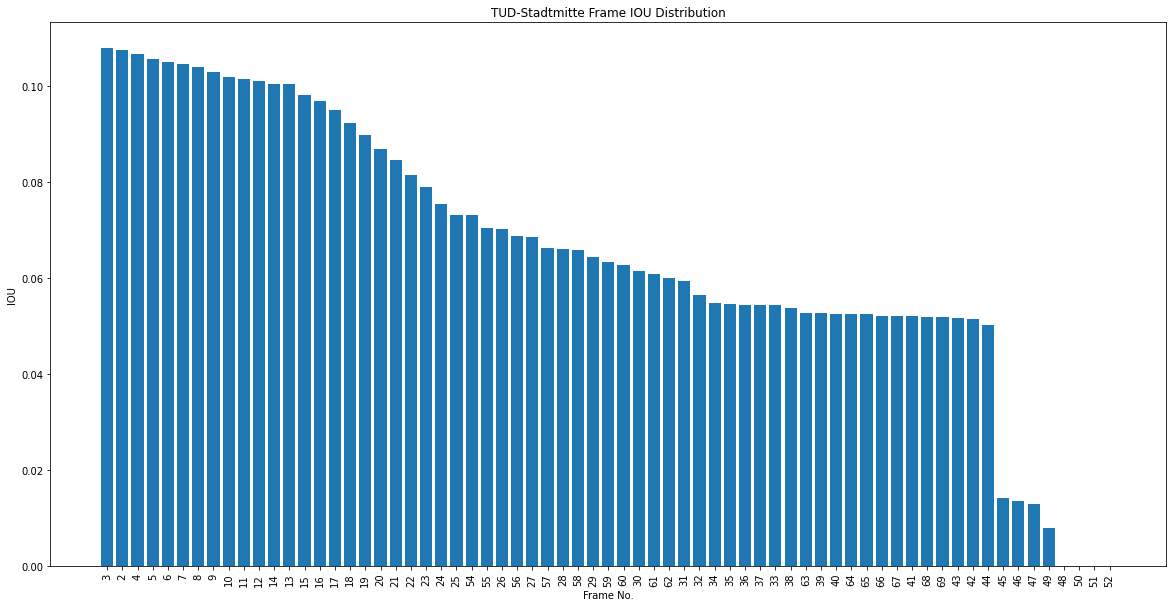

In [ ]:
getter = ImgGetter('TUD-Stadtmitte')
kcf_frame_ious = detect_and_track(getter, clf, pca, 70)
plot_iou_distribution(kcf_frame_ious, 'TUD-Stadtmitte')

In [ ]:
# run on test set
dataset = 'TUD-Crossing'
getter = ImgGetter(dataset, False)
kcf_frame_ious = detect_and_track(getter, clf, pca, 70, False)

Waiting for display
